In [ ]:
# !pip install wandb

In [3]:
!pip install -q einops==0.3.0


In [4]:
# INSTALL AND IMPORT REQUIRED MODULES

!python -c "import monai" || pip install -q "monai-weekly[pillow, tqdm, einops]"
!python -c "import matplotlib" || pip install -q matplotlib
!pip install git+https://github.com/PyTorchLightning/pytorch-lightning
!pip install torchtext



Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/PyTorchLightning/pytorch-lightning to /tmp/pip-req-build-67a_g8vf
  Running command git clone -q https://github.com/PyTorchLightning/pytorch-lightning /tmp/pip-req-build-67a_g8vf
  Running command git submodule update --init --recursive -q
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [5]:
import pytorch_lightning as pl
%matplotlib inline

import os
import shutil
import tempfile
import matplotlib.pyplot as plt
import PIL
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as T
import pytorch_lightning as pl
from pytorch_lightning.callbacks import LearningRateMonitor, ModelCheckpoint
import numpy as np
import math 
from sklearn.metrics import classification_report
from itertools import repeat

from monai.apps import download_and_extract
from monai.config import print_config
from monai.data import decollate_batch
from monai.metrics import DiceMetric
from monai.networks.nets import DenseNet121
from monai.transforms import (
    Activations,
    AddChannel,
    AsDiscreted,
    Compose,
    LoadImage,
    RandFlip,
    RandRotate,
    RandZoom,
    ScaleIntensity,
    EnsureType,
    AddChannelD,
    ResizeD,
    LoadImaged,
    AsChannelFirstd,
    NormalizeIntensityd,
    AsDiscrete,
    ToTensord
)
from monai.utils import set_determinism
from monai.losses import DiceCELoss
from monai.inferers import sliding_window_inference

from monai.apps import DecathlonDataset


from monai.data import (
    DataLoader,
    CacheDataset,
    load_decathlon_datalist,
    decollate_batch,
    list_data_collate,
)
from monai.networks.nets import UNETR

os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.backends.cudnn.benchmark = True
print_config()

MONAI version: 0.10.dev2229
Numpy version: 1.21.6
Pytorch version: 1.12.0+cu113
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: 63964a5f3dbc4e2cb7a66f2da9a385c98e87e846
MONAI __file__: /usr/local/lib/python3.7/dist-packages/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: NOT INSTALLED or UNKNOWN VERSION.
Nibabel version: 3.0.2
scikit-image version: 0.18.3
Pillow version: 7.1.2
Tensorboard version: 2.9.1
gdown version: 4.4.0
TorchVision version: 0.13.0+cu113
tqdm version: 4.64.0
lmdb version: 0.99
psutil version: 5.4.8
pandas version: 1.3.5
einops version: 0.3.0
transformers version: NOT INSTALLED or UNKNOWN VERSION.
mlflow version: NOT INSTALLED or UNKNOWN VERSION.
pynrrd version: NOT INSTALLED or UNKNOWN VERSION.

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#installing-the-recommended-dependencies



In [ ]:
import wandb
wandb.login(relogin=True)

In [ ]:
from pytorch_lightning.loggers import WandbLogger

In [48]:
KEYS = ("image", "label")
train_transform = Compose(
    [
        # load 4 Nifti images and stack them together
        LoadImaged(keys=["image", "label"]),
        AddChannelD("label"),        
        AsChannelFirstd(keys="image"),
        
        ResizeD(KEYS,(96,96,16), mode=('trilinear', 'nearest')),
        #AsDiscreted(keys="label", to_onehot=3),
        NormalizeIntensityd(keys="image", nonzero=True, channel_wise=True),
        ToTensord(keys=["image", "label"]),
        
    ]
)
val_transform = Compose(
    [
        # load 4 Nifti images and stack them together
        LoadImaged(keys=["image", "label"]),
        
        AsChannelFirstd(keys="image"),
        
        AddChannelD("label"),
        #AsDiscreted(keys="label", to_onehot=3),
        ResizeD(KEYS,(96,96,16), mode=('trilinear', 'nearest')),
        NormalizeIntensityd(keys="image", nonzero=True, channel_wise=True),
        ToTensord(keys=["image", "label"]),
        
    ]
)

In [49]:
root_dir = './' 
print(root_dir)
set_determinism(seed=0)



./


In [50]:
#batch_size = 2
cache_num = 8

train_ds = DecathlonDataset(
    root_dir=root_dir,
    task="Task05_Prostate",
    transform=train_transform,
    section="training",
    download=True,
    num_workers=2,
    cache_num=2, # it was 100 but we use larger volumes
)

#train_loader = DataLoader(train_ds[:20], batch_size=batch_size, shuffle=True, num_workers=2)

#train_val_loader = DataLoader(train_ds[20:], batch_size=batch_size, shuffle=False, num_workers=2)

val_ds = DecathlonDataset(
    root_dir=root_dir,
    task="Task05_Prostate",
    transform=val_transform,
    section="validation",
    download=True,
    num_workers=2,
    cache_num=2,
)
#val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False, num_workers=2)

2022-07-18 09:57:40,018 - INFO - Verified 'Task05_Prostate.tar', md5: 35138f08b1efaef89d7424d2bcc928db.
2022-07-18 09:57:40,019 - INFO - File exists: Task05_Prostate.tar, skipped downloading.
2022-07-18 09:57:40,021 - INFO - Non-empty folder exists in Task05_Prostate, skipped extracting.



Loading dataset:   0%|          | 0/2 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:766: UserWarning: Modifying image pixdim from [0.625   0.625   3.60001 1.     ] to [  0.625        0.625        3.60000992 151.21210251]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:766: UserWarning: Modifying image pixdim from [0.625 0.625 3.6   1.   ] to [  0.625        0.625        3.5999999  148.64025265]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")

Loading dataset: 100%|██████████| 2/2 [00:00<00:00,  6.14it/s]


2022-07-18 09:57:40,877 - INFO - Verified 'Task05_Prostate.tar', md5: 35138f08b1efaef89d7424d2bcc928db.
2022-07-18 09:57:40,879 - INFO - File exists: Task05_Prostate.tar, skipped downloading.
2022-07-18 09:57:40,883 - INFO - Non-empty folder exists in Task05_Prostate, skipped extracting.



/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:766: UserWarning: Modifying image pixdim from [0.625   0.625   3.59999 1.     ] to [  0.625        0.625        3.59998989 208.35237358]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:766: UserWarning: Modifying image pixdim from [0.625 0.625 3.6   1.   ] to [  0.625       0.625       3.5999999 149.7974827]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
Loading dataset: 100%|██████████| 2/2 [00:00<00:00,  6.07it/s]


image shape: torch.Size([2, 96, 96, 16])
label shape: torch.Size([1, 96, 96, 16])


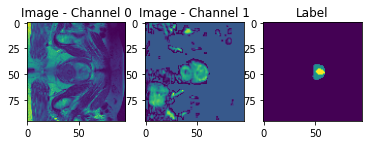

In [51]:
slice_id = 6 
print(f"image shape: {train_ds[:20][0]['image'].shape}")

print(f"label shape: {train_ds[:20][0]['label'].shape}")
plt.subplot(1, 3, 1)
plt.title('Image - Channel 0')
plt.imshow(train_ds[:20][0]['image'][0,:,:,slice_id])
plt.subplot(1, 3, 2)
plt.title('Image - Channel 1')
plt.imshow(train_ds[:20][0]['image'][1,:,:,slice_id])
plt.subplot(1, 3, 3)
plt.title('Label')
plt.imshow(train_ds[:20][0]['label'][0,:,:,slice_id])
plt.show()

In [52]:
train_ds[:20][0]['label'].view(train_ds[:20][0]['label'].size(0), -1).unique(dim=1)



tensor([[0., 1., 2.]])

In [53]:
class Net(pl.LightningModule):
    def __init__(self, config):

        super().__init__()
        
        self._model = UNETR(
            in_channels = config['in_channels'],
            out_channels = config['out_channels'],
            img_size = config['image_size'],
            feature_size = config['feature_size'],
            hidden_size = config['hidden_size'],
            mlp_dim=config['mlp_dim'],
            num_heads=config['num_heads'],
            pos_embed=config['pos_embed'],
            norm_name=config['norm_name'],
            res_block=config['res_block'],
            conv_block=config["conv_block"],
            dropout_rate=config["dropout"],
        )

        self.root_dir = dir
        self.loss_function = DiceCELoss(to_onehot_y=True, softmax=True)
        self.post_pred = AsDiscrete(argmax=True, to_onehot=3)
        self.post_label = AsDiscrete(to_onehot=3)
        self.dice_metric = DiceMetric(
            include_background=True, reduction="mean", get_not_nans=False #check incl_background
        )
        
        self.best_val_dice = 0
        self.best_val_epoch = 0
        self.max_epochs = config['epochs']
        self.check_val = 1 #30
        self.warmup_epochs = 1 #20
        self.metric_values = []
        self.epoch_loss_values = []
        self.learning_rate = config['lr']
        self.batch_size = config["batch_size"]
        self.roi_size = config["roi_size"]
        self.lr_factor = config["lr_factor"]
        self.save_hyperparameters()


    def forward(self, x):
        return self._model(x)

    def configure_optimizers(self):
        self.optimizer = torch.optim.AdamW(self.parameters(), lr=self.learning_rate)
     
        return [self.optimizer]
  
    ## Train, Val, Test
    def training_step(self, batch, batch_idx):
        images, labels = (batch["image"], batch["label"])
        output = self.forward(images)
        loss = self.loss_function(output, labels)
        self.log("train_loss", loss)
 
        return loss

    def training_epoch_end(self, outputs):
        avg_loss = torch.stack([x["loss"] for x in outputs]).mean()
        self.epoch_loss_values.append(avg_loss.detach().cpu().numpy())

    def validation_step(self, batch, batch_idx):
        images, labels = batch["image"], batch["label"]
        roi_size = self.roi_size
        sw_batch_size = self.batch_size
      
        outputs = sliding_window_inference(
            images, roi_size, sw_batch_size, self.forward, overlap=0.6
         )
        loss = self.loss_function(outputs, labels)
        self.val_loss = loss
        outputs = [self.post_pred(i) for i in decollate_batch(outputs)]
        labels = [self.post_label(i) for i in decollate_batch(labels)]

        self.dice_metric(y_pred=outputs, y=labels)
        self.log("val_loss", loss)
        # self.log('lr', self.optimizer.param_groups[0]['lr'])
        #wandb.log({"val_loss": loss})
        #self.log("val_loss", loss,on_step=True, on_epoch=True, prog_bar=True, logger=True)
        return {"val_loss": loss, "val_number": len(outputs)}


    def validation_epoch_end(self, outputs):
        val_loss, num_items = 0, 0
        for output in outputs:            
            val_loss += output["val_loss"].sum().item()
            num_items += output["val_number"]
        mean_val_dice = self.dice_metric.aggregate().item()
        self.dice_metric.reset()
        mean_val_loss = torch.tensor(val_loss / num_items)

        self.log( "mean_val_epoch_dice", mean_val_dice)
        self.log( "mean_val_epoch_loss", mean_val_loss)
        tensorboard_logs = {
            "val_dice": mean_val_dice,
            "val_loss": mean_val_loss,
        }
        if mean_val_dice > self.best_val_dice:
            self.best_val_dice = mean_val_dice
            self.best_val_epoch = self.current_epoch
        print(
            f"current epoch: {self.current_epoch} "
            f"current mean dice: {mean_val_dice:.4f}"
            f"\nbest mean dice: {self.best_val_dice:.4f} "
            f"at epoch: {self.best_val_epoch}"
        )
        self.metric_values.append(mean_val_dice)
        return {"log": tensorboard_logs}   

    # def optimizer_step(self,
    #                  epoch=None, 
    #                 batch_idx=None, 
    #                 optimizer=None, 
    #                 optimizer_idx=None, 
    #                 optimizer_closure=None, 
    #                 on_tpu=None, 
    #                 using_native_amp=None, 
    #                 using_lbfgs=None):
    #     optimizer.step(closure=optimizer_closure)
    #     optimizer.zero_grad()
    #     #if self.trainer.global_step % self.trainer.val_check_interval == 0:
    #     self.scheduler.step(self.val_loss)
        


    def _get_preds_loss_dice(batch):
        pass
   

## Overfit for a sample

In [ ]:
train_overfit_loader = DataLoader(train_ds[0:1], batch_size=1, shuffle=True, num_workers=1)
train_val_overfit_loader = DataLoader(train_ds[0:1], batch_size=1, shuffle=False, num_workers=1)

In [ ]:
len(train_overfit_loader.dataset)

1

In [ ]:

train_overfit_loader.dataset[0]['label'].shape

torch.Size([1, 160, 160, 16])

In [ ]:
torch.manual_seed(42)

In [12]:
config = {
     'in_channels' : 2,
     'out_channels' : 3,
     'image_size' : (160,160,16),
     'feature_size': 16,
     'hidden_size': 256,
     "roi_size": (160,160,16),
     'mlp_dim': 256,
     'num_heads': 8,
     'pos_embed': 'conv',
     'norm_name': "batch",
     "res_block": True,
     "conv_block": True,
     "dropout": 0,
     "lr": 1e-02,
     "batch_size": 2,
     "epochs": 80,
     "lr_factor": 0.02

}

model = Net(config)


In [ ]:
checkpoint_callback = ModelCheckpoint(dirpath=root_dir, filename="best_metric_model")

name = "overfit_" + str(config["epochs"]) + "_" + str(config["batch_size"]) + "_" + str(config["lr"])

config={"epochs": config["epochs"], 
        "batch_size": config["batch_size"], 
        "roi_size": config["roi_size"],
        'num_heads': config['num_heads']}

#wandb.init(project = "unetr_seg", config=config, name = name)
wandb_logger = WandbLogger(project='unetr_seg', name = name) 
wandb_logger.experiment.config.update(config)


#add gpu
trainer = pl.Trainer(logger=wandb_logger, max_epochs=model.max_epochs, 
                     log_every_n_steps=1, check_val_every_n_epoch=1, 
                     callbacks=checkpoint_callback)

# train
trainer.fit(model,train_overfit_loader,train_val_overfit_loader)

wandb.finish()

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/loggers/wandb.py:348: UserWarning: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
  "There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse"
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:613: UserWarning: Checkpoint directory /content exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")

  | Name          | Type       | Params
---------------------------------------------
0 | _model        | UNETR      | 9.9 M 
1 | loss_function | DiceCELoss | 0     
---------------------------------------------
9.9 M     Trainable p

Sanity Checking: 0it [00:00, ?it/s]

(3, 160, 160, 16)  :  (3, 160, 160, 16)
current epoch: 0 current mean dice: 0.0036
best mean dice: 0.0036 at epoch: 0


/usr/local/lib/python3.7/dist-packages/pytorch_lightning/utilities/data.py:86: UserWarning: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 1. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
  "Trying to infer the `batch_size` from an ambiguous collection. The batch size we"


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

(3, 160, 160, 16)  :  (3, 160, 160, 16)
current epoch: 0 current mean dice: 0.0706
best mean dice: 0.0706 at epoch: 0


Validation: 0it [00:00, ?it/s]

(3, 160, 160, 16)  :  (3, 160, 160, 16)
current epoch: 1 current mean dice: 0.0299
best mean dice: 0.0706 at epoch: 0


Validation: 0it [00:00, ?it/s]

(3, 160, 160, 16)  :  (3, 160, 160, 16)
current epoch: 2 current mean dice: 0.0044
best mean dice: 0.0706 at epoch: 0


Validation: 0it [00:00, ?it/s]

(3, 160, 160, 16)  :  (3, 160, 160, 16)
current epoch: 3 current mean dice: 0.0043
best mean dice: 0.0706 at epoch: 0


Validation: 0it [00:00, ?it/s]

(3, 160, 160, 16)  :  (3, 160, 160, 16)
current epoch: 4 current mean dice: 0.0062
best mean dice: 0.0706 at epoch: 0


Validation: 0it [00:00, ?it/s]

(3, 160, 160, 16)  :  (3, 160, 160, 16)
current epoch: 5 current mean dice: 0.0359
best mean dice: 0.0706 at epoch: 0


Validation: 0it [00:00, ?it/s]

(3, 160, 160, 16)  :  (3, 160, 160, 16)
current epoch: 6 current mean dice: 0.0988
best mean dice: 0.0988 at epoch: 6


Validation: 0it [00:00, ?it/s]

(3, 160, 160, 16)  :  (3, 160, 160, 16)
current epoch: 7 current mean dice: 0.1743
best mean dice: 0.1743 at epoch: 7


Validation: 0it [00:00, ?it/s]

(3, 160, 160, 16)  :  (3, 160, 160, 16)
current epoch: 8 current mean dice: 0.2149
best mean dice: 0.2149 at epoch: 8


Validation: 0it [00:00, ?it/s]

(3, 160, 160, 16)  :  (3, 160, 160, 16)
current epoch: 9 current mean dice: 0.2516
best mean dice: 0.2516 at epoch: 9


Validation: 0it [00:00, ?it/s]

(3, 160, 160, 16)  :  (3, 160, 160, 16)
current epoch: 10 current mean dice: 0.2889
best mean dice: 0.2889 at epoch: 10


Validation: 0it [00:00, ?it/s]

(3, 160, 160, 16)  :  (3, 160, 160, 16)
current epoch: 11 current mean dice: 0.3205
best mean dice: 0.3205 at epoch: 11


Validation: 0it [00:00, ?it/s]

(3, 160, 160, 16)  :  (3, 160, 160, 16)
current epoch: 12 current mean dice: 0.3470
best mean dice: 0.3470 at epoch: 12


Validation: 0it [00:00, ?it/s]

(3, 160, 160, 16)  :  (3, 160, 160, 16)
current epoch: 13 current mean dice: 0.3607
best mean dice: 0.3607 at epoch: 13


Validation: 0it [00:00, ?it/s]

(3, 160, 160, 16)  :  (3, 160, 160, 16)
current epoch: 14 current mean dice: 0.3748
best mean dice: 0.3748 at epoch: 14


Validation: 0it [00:00, ?it/s]

(3, 160, 160, 16)  :  (3, 160, 160, 16)
current epoch: 15 current mean dice: 0.3921
best mean dice: 0.3921 at epoch: 15


Validation: 0it [00:00, ?it/s]

(3, 160, 160, 16)  :  (3, 160, 160, 16)
current epoch: 16 current mean dice: 0.3940
best mean dice: 0.3940 at epoch: 16


Validation: 0it [00:00, ?it/s]

(3, 160, 160, 16)  :  (3, 160, 160, 16)
current epoch: 17 current mean dice: 0.4091
best mean dice: 0.4091 at epoch: 17


Validation: 0it [00:00, ?it/s]

(3, 160, 160, 16)  :  (3, 160, 160, 16)
current epoch: 18 current mean dice: 0.4160
best mean dice: 0.4160 at epoch: 18


Validation: 0it [00:00, ?it/s]

(3, 160, 160, 16)  :  (3, 160, 160, 16)
current epoch: 19 current mean dice: 0.4719
best mean dice: 0.4719 at epoch: 19


Validation: 0it [00:00, ?it/s]

(3, 160, 160, 16)  :  (3, 160, 160, 16)
current epoch: 20 current mean dice: 0.4848
best mean dice: 0.4848 at epoch: 20


Validation: 0it [00:00, ?it/s]

(3, 160, 160, 16)  :  (3, 160, 160, 16)
current epoch: 21 current mean dice: 0.4989
best mean dice: 0.4989 at epoch: 21


Validation: 0it [00:00, ?it/s]

(3, 160, 160, 16)  :  (3, 160, 160, 16)
current epoch: 22 current mean dice: 0.5071
best mean dice: 0.5071 at epoch: 22


Validation: 0it [00:00, ?it/s]

(3, 160, 160, 16)  :  (3, 160, 160, 16)
current epoch: 23 current mean dice: 0.5156
best mean dice: 0.5156 at epoch: 23


Validation: 0it [00:00, ?it/s]

(3, 160, 160, 16)  :  (3, 160, 160, 16)
current epoch: 24 current mean dice: 0.5345
best mean dice: 0.5345 at epoch: 24


Validation: 0it [00:00, ?it/s]

(3, 160, 160, 16)  :  (3, 160, 160, 16)
current epoch: 25 current mean dice: 0.5493
best mean dice: 0.5493 at epoch: 25


Validation: 0it [00:00, ?it/s]

(3, 160, 160, 16)  :  (3, 160, 160, 16)
current epoch: 26 current mean dice: 0.5738
best mean dice: 0.5738 at epoch: 26


Validation: 0it [00:00, ?it/s]

(3, 160, 160, 16)  :  (3, 160, 160, 16)
current epoch: 27 current mean dice: 0.6210
best mean dice: 0.6210 at epoch: 27


Validation: 0it [00:00, ?it/s]

(3, 160, 160, 16)  :  (3, 160, 160, 16)
current epoch: 28 current mean dice: 0.6296
best mean dice: 0.6296 at epoch: 28


Validation: 0it [00:00, ?it/s]

(3, 160, 160, 16)  :  (3, 160, 160, 16)
current epoch: 29 current mean dice: 0.6465
best mean dice: 0.6465 at epoch: 29


Validation: 0it [00:00, ?it/s]

(3, 160, 160, 16)  :  (3, 160, 160, 16)
current epoch: 30 current mean dice: 0.7082
best mean dice: 0.7082 at epoch: 30


Validation: 0it [00:00, ?it/s]

(3, 160, 160, 16)  :  (3, 160, 160, 16)
current epoch: 31 current mean dice: 0.7434
best mean dice: 0.7434 at epoch: 31


Validation: 0it [00:00, ?it/s]

(3, 160, 160, 16)  :  (3, 160, 160, 16)
current epoch: 32 current mean dice: 0.7930
best mean dice: 0.7930 at epoch: 32


Validation: 0it [00:00, ?it/s]

(3, 160, 160, 16)  :  (3, 160, 160, 16)
current epoch: 33 current mean dice: 0.8327
best mean dice: 0.8327 at epoch: 33


Validation: 0it [00:00, ?it/s]

(3, 160, 160, 16)  :  (3, 160, 160, 16)
current epoch: 34 current mean dice: 0.8623
best mean dice: 0.8623 at epoch: 34


Validation: 0it [00:00, ?it/s]

(3, 160, 160, 16)  :  (3, 160, 160, 16)
current epoch: 35 current mean dice: 0.8569
best mean dice: 0.8623 at epoch: 34


Validation: 0it [00:00, ?it/s]

(3, 160, 160, 16)  :  (3, 160, 160, 16)
current epoch: 36 current mean dice: 0.8858
best mean dice: 0.8858 at epoch: 36


Validation: 0it [00:00, ?it/s]

(3, 160, 160, 16)  :  (3, 160, 160, 16)
current epoch: 37 current mean dice: 0.8999
best mean dice: 0.8999 at epoch: 37


Validation: 0it [00:00, ?it/s]

(3, 160, 160, 16)  :  (3, 160, 160, 16)
current epoch: 38 current mean dice: 0.9070
best mean dice: 0.9070 at epoch: 38


Validation: 0it [00:00, ?it/s]

(3, 160, 160, 16)  :  (3, 160, 160, 16)
current epoch: 39 current mean dice: 0.9095
best mean dice: 0.9095 at epoch: 39


Validation: 0it [00:00, ?it/s]

(3, 160, 160, 16)  :  (3, 160, 160, 16)
current epoch: 40 current mean dice: 0.9203
best mean dice: 0.9203 at epoch: 40


Validation: 0it [00:00, ?it/s]

(3, 160, 160, 16)  :  (3, 160, 160, 16)
current epoch: 41 current mean dice: 0.9111
best mean dice: 0.9203 at epoch: 40


Validation: 0it [00:00, ?it/s]

(3, 160, 160, 16)  :  (3, 160, 160, 16)
current epoch: 42 current mean dice: 0.9168
best mean dice: 0.9203 at epoch: 40


Validation: 0it [00:00, ?it/s]

(3, 160, 160, 16)  :  (3, 160, 160, 16)
current epoch: 43 current mean dice: 0.9085
best mean dice: 0.9203 at epoch: 40


Validation: 0it [00:00, ?it/s]

(3, 160, 160, 16)  :  (3, 160, 160, 16)
current epoch: 44 current mean dice: 0.9275
best mean dice: 0.9275 at epoch: 44


Validation: 0it [00:00, ?it/s]

(3, 160, 160, 16)  :  (3, 160, 160, 16)
current epoch: 45 current mean dice: 0.9228
best mean dice: 0.9275 at epoch: 44


Validation: 0it [00:00, ?it/s]

(3, 160, 160, 16)  :  (3, 160, 160, 16)
current epoch: 46 current mean dice: 0.9232
best mean dice: 0.9275 at epoch: 44


Validation: 0it [00:00, ?it/s]

(3, 160, 160, 16)  :  (3, 160, 160, 16)
current epoch: 47 current mean dice: 0.9376
best mean dice: 0.9376 at epoch: 47


Validation: 0it [00:00, ?it/s]

(3, 160, 160, 16)  :  (3, 160, 160, 16)
current epoch: 48 current mean dice: 0.9437
best mean dice: 0.9437 at epoch: 48


Validation: 0it [00:00, ?it/s]

(3, 160, 160, 16)  :  (3, 160, 160, 16)
current epoch: 49 current mean dice: 0.9405
best mean dice: 0.9437 at epoch: 48


Validation: 0it [00:00, ?it/s]

(3, 160, 160, 16)  :  (3, 160, 160, 16)
current epoch: 50 current mean dice: 0.9371
best mean dice: 0.9437 at epoch: 48


Validation: 0it [00:00, ?it/s]

(3, 160, 160, 16)  :  (3, 160, 160, 16)
current epoch: 51 current mean dice: 0.9476
best mean dice: 0.9476 at epoch: 51


Validation: 0it [00:00, ?it/s]

(3, 160, 160, 16)  :  (3, 160, 160, 16)
current epoch: 52 current mean dice: 0.9494
best mean dice: 0.9494 at epoch: 52


Validation: 0it [00:00, ?it/s]

(3, 160, 160, 16)  :  (3, 160, 160, 16)
current epoch: 53 current mean dice: 0.9487
best mean dice: 0.9494 at epoch: 52


Validation: 0it [00:00, ?it/s]

(3, 160, 160, 16)  :  (3, 160, 160, 16)
current epoch: 54 current mean dice: 0.9498
best mean dice: 0.9498 at epoch: 54


Validation: 0it [00:00, ?it/s]

(3, 160, 160, 16)  :  (3, 160, 160, 16)
current epoch: 55 current mean dice: 0.9517
best mean dice: 0.9517 at epoch: 55


Validation: 0it [00:00, ?it/s]

(3, 160, 160, 16)  :  (3, 160, 160, 16)
current epoch: 56 current mean dice: 0.9576
best mean dice: 0.9576 at epoch: 56


Validation: 0it [00:00, ?it/s]

(3, 160, 160, 16)  :  (3, 160, 160, 16)
current epoch: 57 current mean dice: 0.9562
best mean dice: 0.9576 at epoch: 56


Validation: 0it [00:00, ?it/s]

(3, 160, 160, 16)  :  (3, 160, 160, 16)
current epoch: 58 current mean dice: 0.9579
best mean dice: 0.9579 at epoch: 58


Validation: 0it [00:00, ?it/s]

(3, 160, 160, 16)  :  (3, 160, 160, 16)
current epoch: 59 current mean dice: 0.9647
best mean dice: 0.9647 at epoch: 59


Validation: 0it [00:00, ?it/s]

(3, 160, 160, 16)  :  (3, 160, 160, 16)
current epoch: 60 current mean dice: 0.9708
best mean dice: 0.9708 at epoch: 60


Validation: 0it [00:00, ?it/s]

(3, 160, 160, 16)  :  (3, 160, 160, 16)
current epoch: 61 current mean dice: 0.9706
best mean dice: 0.9708 at epoch: 60


Validation: 0it [00:00, ?it/s]

(3, 160, 160, 16)  :  (3, 160, 160, 16)
current epoch: 62 current mean dice: 0.9716
best mean dice: 0.9716 at epoch: 62


Validation: 0it [00:00, ?it/s]

(3, 160, 160, 16)  :  (3, 160, 160, 16)
current epoch: 63 current mean dice: 0.9766
best mean dice: 0.9766 at epoch: 63


Validation: 0it [00:00, ?it/s]

(3, 160, 160, 16)  :  (3, 160, 160, 16)
current epoch: 64 current mean dice: 0.9770
best mean dice: 0.9770 at epoch: 64


Validation: 0it [00:00, ?it/s]

(3, 160, 160, 16)  :  (3, 160, 160, 16)
current epoch: 65 current mean dice: 0.9795
best mean dice: 0.9795 at epoch: 65


Validation: 0it [00:00, ?it/s]

(3, 160, 160, 16)  :  (3, 160, 160, 16)
current epoch: 66 current mean dice: 0.9780
best mean dice: 0.9795 at epoch: 65


Validation: 0it [00:00, ?it/s]

(3, 160, 160, 16)  :  (3, 160, 160, 16)
current epoch: 67 current mean dice: 0.9828
best mean dice: 0.9828 at epoch: 67


Validation: 0it [00:00, ?it/s]

(3, 160, 160, 16)  :  (3, 160, 160, 16)
current epoch: 68 current mean dice: 0.9822
best mean dice: 0.9828 at epoch: 67


Validation: 0it [00:00, ?it/s]

(3, 160, 160, 16)  :  (3, 160, 160, 16)
current epoch: 69 current mean dice: 0.9850
best mean dice: 0.9850 at epoch: 69


Validation: 0it [00:00, ?it/s]

(3, 160, 160, 16)  :  (3, 160, 160, 16)
current epoch: 70 current mean dice: 0.9830
best mean dice: 0.9850 at epoch: 69


Validation: 0it [00:00, ?it/s]

(3, 160, 160, 16)  :  (3, 160, 160, 16)
current epoch: 71 current mean dice: 0.9864
best mean dice: 0.9864 at epoch: 71


Validation: 0it [00:00, ?it/s]

(3, 160, 160, 16)  :  (3, 160, 160, 16)
current epoch: 72 current mean dice: 0.9864
best mean dice: 0.9864 at epoch: 71


Validation: 0it [00:00, ?it/s]

(3, 160, 160, 16)  :  (3, 160, 160, 16)
current epoch: 73 current mean dice: 0.9872
best mean dice: 0.9872 at epoch: 73


Validation: 0it [00:00, ?it/s]

(3, 160, 160, 16)  :  (3, 160, 160, 16)
current epoch: 74 current mean dice: 0.9887
best mean dice: 0.9887 at epoch: 74


Validation: 0it [00:00, ?it/s]

(3, 160, 160, 16)  :  (3, 160, 160, 16)
current epoch: 75 current mean dice: 0.9897
best mean dice: 0.9897 at epoch: 75


Validation: 0it [00:00, ?it/s]

(3, 160, 160, 16)  :  (3, 160, 160, 16)
current epoch: 76 current mean dice: 0.9906
best mean dice: 0.9906 at epoch: 76


Validation: 0it [00:00, ?it/s]

(3, 160, 160, 16)  :  (3, 160, 160, 16)
current epoch: 77 current mean dice: 0.9904
best mean dice: 0.9906 at epoch: 76


Validation: 0it [00:00, ?it/s]

(3, 160, 160, 16)  :  (3, 160, 160, 16)
current epoch: 78 current mean dice: 0.9909
best mean dice: 0.9909 at epoch: 78


Validation: 0it [00:00, ?it/s]

(3, 160, 160, 16)  :  (3, 160, 160, 16)
current epoch: 79 current mean dice: 0.9915
best mean dice: 0.9915 at epoch: 79


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
lr,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_val_epoch_dice,▁▁▁▂▂▃▃▄▄▄▄▅▅▅▅▆▇▇▇▇▇▇██████████████████
mean_val_epoch_loss,▁█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss,█▆▅▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
trainer/global_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
val_loss,▁█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,79
lr,0.01
mean_val_epoch_dice,0.99148
mean_val_epoch_loss,0.01778


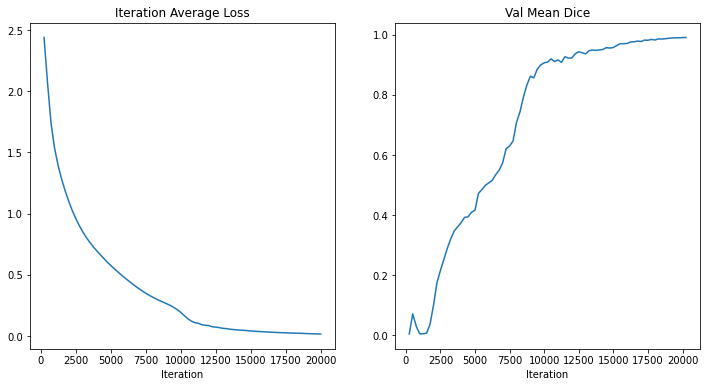

In [ ]:
eval_num = 250
plt.figure("train", (12, 6))
plt.subplot(1, 2, 1)
plt.title("Iteration Average Loss")
x = [eval_num * (i + 1) for i in range(len(model.epoch_loss_values))]
y = model.epoch_loss_values
plt.xlabel("Iteration")
plt.plot(x, y)
plt.subplot(1, 2, 2)
plt.title("Val Mean Dice")
x = [eval_num * (i + 1) for i in range(len(model.metric_values))]
y = model.metric_values
plt.xlabel("Iteration")
plt.plot(x, y)
plt.show()

In [ ]:
print(len(model.epoch_loss_values))

80


In [ ]:
train_ds[0].keys()

dict_keys(['image', 'label', 'image_meta_dict', 'label_meta_dict'])

In [ ]:
train_ds[0]['image_meta_dict']

{'affine': tensor([[   0.6250,    0.0000,    0.0000,  -63.3240],
         [   0.0000,    0.6250,    0.0000, -101.9478],
         [   0.0000,    0.0000,    3.6000,  -91.9827],
         [   0.0000,    0.0000,    0.0000,    1.0000]], dtype=torch.float64),
 'as_closest_canonical': False,
 'bitpix': array(32, dtype=int16),
 'cal_max': array(0., dtype=float32),
 'cal_min': array(0., dtype=float32),
 'datatype': array(16, dtype=int16),
 'dim': array([  4, 320, 320,  20,   2,   1,   1,   1], dtype=int16),
 'dim_info': array(0, dtype=uint8),
 'extents': array(0, dtype=int32),
 'filename_or_obj': 'Task05_Prostate/imagesTr/prostate_46.nii.gz',
 'glmax': array(0, dtype=int32),
 'glmin': array(0, dtype=int32),
 'intent_code': array(0, dtype=int16),
 'intent_p1': array(0., dtype=float32),
 'intent_p2': array(0., dtype=float32),
 'intent_p3': array(0., dtype=float32),
 'original_affine': array([[   0.625     ,    0.        ,    0.        ,  -63.32400513],
        [   0.        ,    0.625     ,    0. 

In [ ]:
train_ds[0]['label_meta_dict']

{'affine': tensor([[   0.6250,    0.0000,    0.0000,  -63.3240],
         [   0.0000,    0.6250,    0.0000, -101.9478],
         [   0.0000,    0.0000,    3.6000,  -91.9827],
         [   0.0000,    0.0000,    0.0000,    1.0000]], dtype=torch.float64),
 'as_closest_canonical': False,
 'bitpix': array(8, dtype=int16),
 'cal_max': array(0., dtype=float32),
 'cal_min': array(0., dtype=float32),
 'datatype': array(2, dtype=int16),
 'dim': array([  3, 320, 320,  20,   1,   1,   1,   1], dtype=int16),
 'dim_info': array(0, dtype=uint8),
 'extents': array(0, dtype=int32),
 'filename_or_obj': 'Task05_Prostate/labelsTr/prostate_46.nii.gz',
 'glmax': array(0, dtype=int32),
 'glmin': array(0, dtype=int32),
 'intent_code': array(0, dtype=int16),
 'intent_p1': array(0., dtype=float32),
 'intent_p2': array(0., dtype=float32),
 'intent_p3': array(0., dtype=float32),
 'original_affine': array([[   0.625     ,    0.        ,    0.        ,  -63.32400513],
        [   0.        ,    0.625     ,    0.   

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


torch.Size([2, 160, 160, 16])
torch.Size([1, 160, 160, 16])
torch.Size([1, 2, 160, 160, 16])
torch.Size([1, 1, 160, 160, 16])


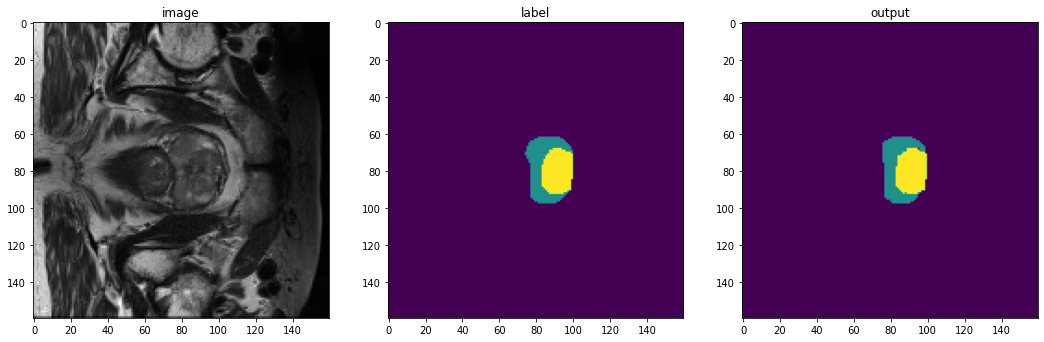

In [ ]:
val_ds = train_ds
case_num = 0
slice_id = 8

#"best_metric_model-v11.ckpt"
model.load_from_checkpoint(os.path.join(root_dir, "best_metric_model-v1.ckpt"))
model.eval()
model.to(device)
net = model

with torch.no_grad():
    img_name = os.path.split(
        val_ds[case_num]["image_meta_dict"]["filename_or_obj"]
    )[1]
    img = val_ds[case_num]["image"].to(device)
    label = val_ds[case_num]["label"].to(device)
    print(img.shape)
    print(label.shape)
    val_inputs = torch.unsqueeze(img, 0).to(device)
    val_labels = torch.unsqueeze(label, 1).to(device)
    print(val_inputs.shape)
    print(val_labels.shape)
    #images, roi_size, sw_batch_size, self.forward
    val_outputs = sliding_window_inference(
        val_inputs, (160, 160, 16),1, net, overlap=0.4
    )
    plt.figure("check", (18, 6))
    plt.subplot(1, 3, 1)
    plt.title(f"image")
    plt.imshow(val_inputs.cpu().numpy()[0, 0, :, :,slice_id], cmap="gray")
    plt.subplot(1, 3, 2)
    plt.title(f"label")
    plt.imshow(val_labels.cpu().numpy()[0, 0, :, :, slice_id])
    plt.subplot(1, 3, 3)
    plt.title(f"output")
    plt.imshow(
        torch.argmax(val_outputs, dim=1).detach().cpu()[0, :, :, slice_id]
    )
    plt.show()

# Train with whole dataset

In [ ]:
train_loader = DataLoader(train_ds[:20], batch_size=16, shuffle=True, num_workers=2)
train_val_loader = DataLoader(train_ds[20:], batch_size=16, shuffle=False, num_workers=2)

In [ ]:
len(train_loader.dataset)

20

In [107]:
config = {
     'in_channels' : 2,
     'out_channels' : 3,
     'image_size' : (96,96,16),
     'feature_size': 16,
     'hidden_size': 512,
     "roi_size": (96,96,16),
     'mlp_dim': 512,
     'num_heads': 16,
     'pos_embed': 'conv',
     'norm_name': "batch",
     "res_block": True,
     "conv_block": True,
     "dropout": 0,
     "lr":1e-02,
     "batch_size": 4,
     "epochs": 80,
     "lr_factor": 0.02

}

model = Net(config)

In [ ]:
checkpoint_callback = ModelCheckpoint(dirpath=root_dir, filename="best_metric_model")

name = "full_" + str(config["epochs"]) + "_" + str(config["batch_size"]) + "_" + str(config["lr"])

config_wdb={"epochs": config["epochs"], 
        "batch_size": config["batch_size"], 
        "roi_size": config["roi_size"],
        'num_heads': config['num_heads']}

#wandb.init(project = "unetr_seg", config=config, name = name)
wandb_logger = WandbLogger(project='unetr_seg', name = name) 
wandb_logger.experiment.config.update(config_wdb)


#add gpu
trainer = pl.Trainer(logger=wandb_logger, max_epochs=model.max_epochs, 
                     log_every_n_steps=1, check_val_every_n_epoch=1, 
                     callbacks=checkpoint_callback)

# train
trainer.fit(model,train_loader,train_val_loader)

wandb.finish()

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/trainer.py:1765: PossibleUserWarning: GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.
  category=PossibleUserWarning,
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:613: UserWarning: Checkpoint directory /content exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")

  | Name          | Type       | Params
---------------------------------------------
0 | _model        | UNETR      | 11.4 M
1 | loss_function | DiceCELoss | 0     
---------------------------------------------
11.4 M    Trainable params
0         Non-trainable params
11.4 M    Total params
45.708    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:727: UserWarning: Modifying image pixdim from [0.625 0.625 3.6   1.   ] to [  0.625        0.625        3.5999999  150.52861008]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:727: UserWarning: Modifying image pixdim from [0.625   0.625   3.60001 1.     ] to [  0.625        0.625        3.60000992 149.1610426 ]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:727: UserWarning: Modifying image pixdim from [0.625 0.625 3.6   1.   ] to [  0.625        0.625        3.5999999  150.20609596]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:727: UserWarning: Modifying image pixdim from [0.6249998 0.625     3.5999987 1.       ] to [  0.62499983   0.625        3.59999877 153.34152766]
  warnings.warn(f"Modif

current epoch: 0 current mean dice: 0.3270
best mean dice: 0.3270 at epoch: 0


Training: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:727: UserWarning: Modifying image pixdim from [0.625 0.625 3.6   1.   ] to [  0.625        0.625        3.5999999  160.67573396]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:727: UserWarning: Modifying image pixdim from [0.75      0.7500001 4.0000005 1.       ] to [  0.75         0.75000013   4.00000043 128.6789431 ]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:727: UserWarning: Modifying image pixdim from [0.75       0.74999964 2.9999986  1.        ] to [  0.75         0.74999965   2.99999861 157.50724574]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:727: UserWarning: Modifying image pixdim from [0.6        0.60000014 4.0000005  1.        ] to [  0.60000002   0.60000017   4.00000043 128.8

Validation: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:727: UserWarning: Modifying image pixdim from [0.625 0.625 3.6   1.   ] to [  0.625        0.625        3.5999999  150.52861008]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:727: UserWarning: Modifying image pixdim from [0.625   0.625   3.60001 1.     ] to [  0.625        0.625        3.60000992 149.1610426 ]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:727: UserWarning: Modifying image pixdim from [0.625 0.625 3.6   1.   ] to [  0.625        0.625        3.5999999  150.20609596]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:727: UserWarning: Modifying image pixdim from [0.6249998 0.625     3.5999987 1.       ] to [  0.62499983   0.625        3.59999877 153.34152766]
  warnings.warn(f"Modif

current epoch: 0 current mean dice: 0.3320
best mean dice: 0.3320 at epoch: 0


/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:727: UserWarning: Modifying image pixdim from [0.625 0.625 3.6   1.   ] to [  0.625        0.625        3.5999999  154.70488398]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:727: UserWarning: Modifying image pixdim from [0.75 0.75 4.   1.  ] to [  0.75         0.75         4.00000005 134.2148206 ]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:727: UserWarning: Modifying image pixdim from [0.625 0.625 3.6   1.   ] to [  0.625       0.625       3.5999999 151.7973753]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:727: UserWarning: Modifying image pixdim from [0.625 0.625 3.6   1.   ] to [  0.625        0.625        3.5999999  160.67573396]
  warnings.warn(f"Modifying image pixdim from {pixdim} 

Validation: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:727: UserWarning: Modifying image pixdim from [0.625 0.625 3.6   1.   ] to [  0.625        0.625        3.5999999  150.52861008]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:727: UserWarning: Modifying image pixdim from [0.625   0.625   3.60001 1.     ] to [  0.625        0.625        3.60000992 149.1610426 ]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:727: UserWarning: Modifying image pixdim from [0.625 0.625 3.6   1.   ] to [  0.625        0.625        3.5999999  150.20609596]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:727: UserWarning: Modifying image pixdim from [0.6249998 0.625     3.5999987 1.       ] to [  0.62499983   0.625        3.59999877 153.34152766]
  warnings.warn(f"Modif

current epoch: 1 current mean dice: 0.3472
best mean dice: 0.3472 at epoch: 1


/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:727: UserWarning: Modifying image pixdim from [0.625 0.625 3.6   1.   ] to [  0.625       0.625       3.5999999 152.3814254]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:727: UserWarning: Modifying image pixdim from [0.6        0.60000014 4.0000005  1.        ] to [  0.60000002   0.60000017   4.00000043 128.8161199 ]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:727: UserWarning: Modifying image pixdim from [0.75 0.75 4.   1.  ] to [  0.75         0.75         4.00000005 134.2148206 ]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:727: UserWarning: Modifying image pixdim from [0.75       0.74999964 2.9999986  1.        ] to [  0.75         0.74999965   2.99999861 157.50724574]
  warnings.warn

Validation: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:727: UserWarning: Modifying image pixdim from [0.625 0.625 3.6   1.   ] to [  0.625        0.625        3.5999999  150.52861008]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:727: UserWarning: Modifying image pixdim from [0.625   0.625   3.60001 1.     ] to [  0.625        0.625        3.60000992 149.1610426 ]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:727: UserWarning: Modifying image pixdim from [0.625 0.625 3.6   1.   ] to [  0.625        0.625        3.5999999  150.20609596]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:727: UserWarning: Modifying image pixdim from [0.6249998 0.625     3.5999987 1.       ] to [  0.62499983   0.625        3.59999877 153.34152766]
  warnings.warn(f"Modif

current epoch: 2 current mean dice: 0.3349
best mean dice: 0.3472 at epoch: 1


/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:727: UserWarning: Modifying image pixdim from [0.625      0.62500006 3.6000001  1.        ] to [  0.625        0.62500005   3.60000016 168.35859116]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:727: UserWarning: Modifying image pixdim from [0.6       0.5999997 3.999998  1.       ] to [  0.60000002   0.59999975   3.99999799 129.0477496 ]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:727: UserWarning: Modifying image pixdim from [0.625 0.625 3.6   1.   ] to [  0.625        0.625        3.5999999  154.70488398]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:727: UserWarning: Modifying image pixdim from [0.625 0.625 3.6   1.   ] to [  0.625       0.625       3.5999999 151.7973753]
  warnings.warn

Validation: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:727: UserWarning: Modifying image pixdim from [0.625 0.625 3.6   1.   ] to [  0.625        0.625        3.5999999  150.52861008]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:727: UserWarning: Modifying image pixdim from [0.625   0.625   3.60001 1.     ] to [  0.625        0.625        3.60000992 149.1610426 ]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:727: UserWarning: Modifying image pixdim from [0.625 0.625 3.6   1.   ] to [  0.625        0.625        3.5999999  150.20609596]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:727: UserWarning: Modifying image pixdim from [0.6249998 0.625     3.5999987 1.       ] to [  0.62499983   0.625        3.59999877 153.34152766]
  warnings.warn(f"Modif

current epoch: 3 current mean dice: 0.2851
best mean dice: 0.3472 at epoch: 1


/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:727: UserWarning: Modifying image pixdim from [0.625 0.625 3.6   1.   ] to [  0.625       0.625       3.5999999 152.3814254]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:727: UserWarning: Modifying image pixdim from [0.75 0.75 4.   1.  ] to [  0.75         0.75         4.00000005 134.2148206 ]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:727: UserWarning: Modifying image pixdim from [0.75       0.74999964 2.9999986  1.        ] to [  0.75         0.74999965   2.99999861 157.50724574]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:727: UserWarning: Modifying image pixdim from [0.6        0.60000014 4.0000005  1.        ] to [  0.60000002   0.60000017   4.00000043 128.8161199 ]
  warnings.warn

Validation: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:727: UserWarning: Modifying image pixdim from [0.625 0.625 3.6   1.   ] to [  0.625        0.625        3.5999999  150.52861008]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:727: UserWarning: Modifying image pixdim from [0.625   0.625   3.60001 1.     ] to [  0.625        0.625        3.60000992 149.1610426 ]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:727: UserWarning: Modifying image pixdim from [0.625 0.625 3.6   1.   ] to [  0.625        0.625        3.5999999  150.20609596]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:727: UserWarning: Modifying image pixdim from [0.6249998 0.625     3.5999987 1.       ] to [  0.62499983   0.625        3.59999877 153.34152766]
  warnings.warn(f"Modif

current epoch: 4 current mean dice: 0.2783
best mean dice: 0.3472 at epoch: 1


/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:727: UserWarning: Modifying image pixdim from [0.625      0.62500006 3.6000001  1.        ] to [  0.625        0.62500005   3.60000016 168.35859116]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:727: UserWarning: Modifying image pixdim from [0.6        0.60000014 4.0000005  1.        ] to [  0.60000002   0.60000017   4.00000041 174.1516677 ]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:727: UserWarning: Modifying image pixdim from [0.62499976 0.62499976 3.6        1.        ] to [  0.62499976   0.62499976   3.5999999  164.74616031]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:727: UserWarning: Modifying image pixdim from [0.625 0.625 3.6   1.   ] to [  0.625        0.625        3.5999999  1

Validation: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:727: UserWarning: Modifying image pixdim from [0.625 0.625 3.6   1.   ] to [  0.625        0.625        3.5999999  150.52861008]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:727: UserWarning: Modifying image pixdim from [0.625   0.625   3.60001 1.     ] to [  0.625        0.625        3.60000992 149.1610426 ]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:727: UserWarning: Modifying image pixdim from [0.625 0.625 3.6   1.   ] to [  0.625        0.625        3.5999999  150.20609596]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:727: UserWarning: Modifying image pixdim from [0.6249998 0.625     3.5999987 1.       ] to [  0.62499983   0.625        3.59999877 153.34152766]
  warnings.warn(f"Modif

current epoch: 5 current mean dice: 0.2914
best mean dice: 0.3472 at epoch: 1


/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:727: UserWarning: Modifying image pixdim from [0.625 0.625 3.6   1.   ] to [  0.625        0.625        3.5999999  160.67573396]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:727: UserWarning: Modifying image pixdim from [0.62499976 0.62499976 3.6        1.        ] to [  0.62499976   0.62499976   3.5999999  164.74616031]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:727: UserWarning: Modifying image pixdim from [0.625 0.625 3.6   1.   ] to [  0.625        0.625        3.5999999  180.81811432]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:727: UserWarning: Modifying image pixdim from [0.625 0.625 3.6   1.   ] to [  0.625        0.625        3.5999999  202.45334114]
  warnings.warn(f"Modifying

Validation: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:727: UserWarning: Modifying image pixdim from [0.625 0.625 3.6   1.   ] to [  0.625        0.625        3.5999999  150.52861008]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:727: UserWarning: Modifying image pixdim from [0.625   0.625   3.60001 1.     ] to [  0.625        0.625        3.60000992 149.1610426 ]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:727: UserWarning: Modifying image pixdim from [0.625 0.625 3.6   1.   ] to [  0.625        0.625        3.5999999  150.20609596]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:727: UserWarning: Modifying image pixdim from [0.6249998 0.625     3.5999987 1.       ] to [  0.62499983   0.625        3.59999877 153.34152766]
  warnings.warn(f"Modif

current epoch: 6 current mean dice: 0.3033
best mean dice: 0.3472 at epoch: 1


/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:727: UserWarning: Modifying image pixdim from [0.625 0.625 3.6   1.   ] to [  0.625       0.625       3.5999999 152.3814254]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:727: UserWarning: Modifying image pixdim from [0.625 0.625 3.6   1.   ] to [  0.625       0.625       3.5999999 151.7973753]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:727: UserWarning: Modifying image pixdim from [0.75      0.7500001 4.0000005 1.       ] to [  0.75         0.75000013   4.00000043 128.6789431 ]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:727: UserWarning: Modifying image pixdim from [0.62499976 0.62499976 3.6        1.        ] to [  0.62499976   0.62499976   3.5999999  164.74616031]
  warnings.warn(f"M

Validation: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:727: UserWarning: Modifying image pixdim from [0.625 0.625 3.6   1.   ] to [  0.625        0.625        3.5999999  150.52861008]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:727: UserWarning: Modifying image pixdim from [0.625   0.625   3.60001 1.     ] to [  0.625        0.625        3.60000992 149.1610426 ]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:727: UserWarning: Modifying image pixdim from [0.625 0.625 3.6   1.   ] to [  0.625        0.625        3.5999999  150.20609596]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:727: UserWarning: Modifying image pixdim from [0.6249998 0.625     3.5999987 1.       ] to [  0.62499983   0.625        3.59999877 153.34152766]
  warnings.warn(f"Modif

current epoch: 7 current mean dice: 0.3273
best mean dice: 0.3472 at epoch: 1


/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:727: UserWarning: Modifying image pixdim from [0.625 0.625 3.6   1.   ] to [  0.625        0.625        3.5999999  170.38896694]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:727: UserWarning: Modifying image pixdim from [0.625 0.625 3.6   1.   ] to [  0.625       0.625       3.5999999 152.3814254]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:727: UserWarning: Modifying image pixdim from [0.625 0.625 3.6   1.   ] to [  0.625        0.625        3.5999999  154.70488398]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:727: UserWarning: Modifying image pixdim from [0.625 0.625 3.6   1.   ] to [  0.625        0.625        3.5999999  180.81811432]
  warnings.warn(f"Modifying image pixdim from {pixd

Validation: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:727: UserWarning: Modifying image pixdim from [0.625 0.625 3.6   1.   ] to [  0.625        0.625        3.5999999  150.52861008]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:727: UserWarning: Modifying image pixdim from [0.625   0.625   3.60001 1.     ] to [  0.625        0.625        3.60000992 149.1610426 ]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:727: UserWarning: Modifying image pixdim from [0.625 0.625 3.6   1.   ] to [  0.625        0.625        3.5999999  150.20609596]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:727: UserWarning: Modifying image pixdim from [0.6249998 0.625     3.5999987 1.       ] to [  0.62499983   0.625        3.59999877 153.34152766]
  warnings.warn(f"Modif

current epoch: 8 current mean dice: 0.3555
best mean dice: 0.3555 at epoch: 8


/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:727: UserWarning: Modifying image pixdim from [0.625 0.625 3.6   1.   ] to [  0.625        0.625        3.5999999  202.45334114]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:727: UserWarning: Modifying image pixdim from [0.6        0.60000014 4.0000005  1.        ] to [  0.60000002   0.60000017   4.00000041 174.1516677 ]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:727: UserWarning: Modifying image pixdim from [0.625 0.625 3.6   1.   ] to [  0.625        0.625        3.5999999  154.70488398]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:727: UserWarning: Modifying image pixdim from [0.6       0.5999997 3.999998  1.       ] to [  0.60000002   0.59999975   3.99999799 117.82332812]
  warnings.

Validation: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:727: UserWarning: Modifying image pixdim from [0.625 0.625 3.6   1.   ] to [  0.625        0.625        3.5999999  150.52861008]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:727: UserWarning: Modifying image pixdim from [0.625   0.625   3.60001 1.     ] to [  0.625        0.625        3.60000992 149.1610426 ]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:727: UserWarning: Modifying image pixdim from [0.625 0.625 3.6   1.   ] to [  0.625        0.625        3.5999999  150.20609596]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:727: UserWarning: Modifying image pixdim from [0.6249998 0.625     3.5999987 1.       ] to [  0.62499983   0.625        3.59999877 153.34152766]
  warnings.warn(f"Modif

current epoch: 9 current mean dice: 0.3852
best mean dice: 0.3852 at epoch: 9


/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:727: UserWarning: Modifying image pixdim from [0.625 0.625 3.6   1.   ] to [  0.625        0.625        3.5999999  170.38896694]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:727: UserWarning: Modifying image pixdim from [0.75       0.74999964 2.9999986  1.        ] to [  0.75         0.74999965   2.99999861 157.50724574]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:727: UserWarning: Modifying image pixdim from [0.6        0.60000014 4.0000005  1.        ] to [  0.60000002   0.60000017   4.00000041 174.1516677 ]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:727: UserWarning: Modifying image pixdim from [0.75      0.7500001 4.0000005 1.       ] to [  0.75         0.75000013   4.00000043 128.6

Validation: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:727: UserWarning: Modifying image pixdim from [0.625 0.625 3.6   1.   ] to [  0.625        0.625        3.5999999  150.52861008]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:727: UserWarning: Modifying image pixdim from [0.625   0.625   3.60001 1.     ] to [  0.625        0.625        3.60000992 149.1610426 ]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:727: UserWarning: Modifying image pixdim from [0.625 0.625 3.6   1.   ] to [  0.625        0.625        3.5999999  150.20609596]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:727: UserWarning: Modifying image pixdim from [0.6249998 0.625     3.5999987 1.       ] to [  0.62499983   0.625        3.59999877 153.34152766]
  warnings.warn(f"Modif

current epoch: 10 current mean dice: 0.3868
best mean dice: 0.3868 at epoch: 10


/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:727: UserWarning: Modifying image pixdim from [0.625 0.625 3.6   1.   ] to [  0.625        0.625        3.5999999  202.45334114]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:727: UserWarning: Modifying image pixdim from [0.75      0.7500001 4.0000005 1.       ] to [  0.75         0.75000013   4.00000043 128.6789431 ]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:727: UserWarning: Modifying image pixdim from [0.6        0.60000014 4.0000005  1.        ] to [  0.60000002   0.60000017   4.00000043 128.8161199 ]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:727: UserWarning: Modifying image pixdim from [0.625 0.625 3.6   1.   ] to [  0.625       0.625       3.5999999 152.3814254]
  warnings.warn

Validation: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:727: UserWarning: Modifying image pixdim from [0.625 0.625 3.6   1.   ] to [  0.625        0.625        3.5999999  150.52861008]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:727: UserWarning: Modifying image pixdim from [0.625   0.625   3.60001 1.     ] to [  0.625        0.625        3.60000992 149.1610426 ]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:727: UserWarning: Modifying image pixdim from [0.625 0.625 3.6   1.   ] to [  0.625        0.625        3.5999999  150.20609596]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:727: UserWarning: Modifying image pixdim from [0.6249998 0.625     3.5999987 1.       ] to [  0.62499983   0.625        3.59999877 153.34152766]
  warnings.warn(f"Modif

current epoch: 11 current mean dice: 0.3821
best mean dice: 0.3868 at epoch: 10


/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:727: UserWarning: Modifying image pixdim from [0.625 0.625 3.6   1.   ] to [  0.625       0.625       3.5999999 152.3814254]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:727: UserWarning: Modifying image pixdim from [0.625 0.625 3.6   1.   ] to [  0.625        0.625        3.5999999  170.38896694]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:727: UserWarning: Modifying image pixdim from [0.625 0.625 3.6   1.   ] to [  0.625        0.625        3.5999999  202.45334114]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:727: UserWarning: Modifying image pixdim from [0.6        0.60000014 4.0000005  1.        ] to [  0.60000002   0.60000017   4.00000041 174.1516677 ]
  warnings.warn(f"Modifying ima

Validation: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:727: UserWarning: Modifying image pixdim from [0.625 0.625 3.6   1.   ] to [  0.625        0.625        3.5999999  150.52861008]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:727: UserWarning: Modifying image pixdim from [0.625   0.625   3.60001 1.     ] to [  0.625        0.625        3.60000992 149.1610426 ]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:727: UserWarning: Modifying image pixdim from [0.625 0.625 3.6   1.   ] to [  0.625        0.625        3.5999999  150.20609596]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:727: UserWarning: Modifying image pixdim from [0.6249998 0.625     3.5999987 1.       ] to [  0.62499983   0.625        3.59999877 153.34152766]
  warnings.warn(f"Modif

current epoch: 12 current mean dice: 0.3770
best mean dice: 0.3868 at epoch: 10


/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:727: UserWarning: Modifying image pixdim from [0.6       0.5999997 3.999998  1.       ] to [  0.60000002   0.59999975   3.99999799 117.82332812]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:727: UserWarning: Modifying image pixdim from [0.625 0.625 3.6   1.   ] to [  0.625       0.625       3.5999999 152.3814254]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:727: UserWarning: Modifying image pixdim from [0.625 0.625 3.6   1.   ] to [  0.625        0.625        3.5999999  160.67573396]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:727: UserWarning: Modifying image pixdim from [0.625 0.625 3.6   1.   ] to [  0.625        0.625        3.5999999  180.81811432]
  warnings.warn(f"Modifying image p

Validation: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:727: UserWarning: Modifying image pixdim from [0.625 0.625 3.6   1.   ] to [  0.625        0.625        3.5999999  150.52861008]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:727: UserWarning: Modifying image pixdim from [0.625   0.625   3.60001 1.     ] to [  0.625        0.625        3.60000992 149.1610426 ]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:727: UserWarning: Modifying image pixdim from [0.625 0.625 3.6   1.   ] to [  0.625        0.625        3.5999999  150.20609596]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:727: UserWarning: Modifying image pixdim from [0.6249998 0.625     3.5999987 1.       ] to [  0.62499983   0.625        3.59999877 153.34152766]
  warnings.warn(f"Modif

current epoch: 13 current mean dice: 0.4164
best mean dice: 0.4164 at epoch: 13


/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:727: UserWarning: Modifying image pixdim from [0.625 0.625 3.6   1.   ] to [  0.625        0.625        3.5999999  154.70488398]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:727: UserWarning: Modifying image pixdim from [0.6        0.60000014 4.0000005  1.        ] to [  0.60000002   0.60000017   4.00000041 174.1516677 ]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:727: UserWarning: Modifying image pixdim from [0.625 0.625 3.6   1.   ] to [  0.625        0.625        3.5999999  162.36758282]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:727: UserWarning: Modifying image pixdim from [0.625 0.625 3.6   1.   ] to [  0.625       0.625       3.5999999 151.7973753]
  warnings.warn(f"Modifying ima

Validation: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:727: UserWarning: Modifying image pixdim from [0.625 0.625 3.6   1.   ] to [  0.625        0.625        3.5999999  150.52861008]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:727: UserWarning: Modifying image pixdim from [0.625   0.625   3.60001 1.     ] to [  0.625        0.625        3.60000992 149.1610426 ]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:727: UserWarning: Modifying image pixdim from [0.625 0.625 3.6   1.   ] to [  0.625        0.625        3.5999999  150.20609596]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:727: UserWarning: Modifying image pixdim from [0.6249998 0.625     3.5999987 1.       ] to [  0.62499983   0.625        3.59999877 153.34152766]
  warnings.warn(f"Modif

current epoch: 14 current mean dice: 0.4562
best mean dice: 0.4562 at epoch: 14


/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:727: UserWarning: Modifying image pixdim from [0.75       0.74999964 2.9999986  1.        ] to [  0.75         0.74999965   2.99999861 157.50724574]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:727: UserWarning: Modifying image pixdim from [0.62499976 0.62499976 3.6        1.        ] to [  0.62499976   0.62499976   3.5999999  164.74616031]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:727: UserWarning: Modifying image pixdim from [0.625 0.625 3.6   1.   ] to [  0.625        0.625        3.5999999  162.36758282]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:727: UserWarning: Modifying image pixdim from [0.625 0.625 3.6   1.   ] to [  0.625       0.625       3.5999999 151.7973753]
  warnings.

Validation: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:727: UserWarning: Modifying image pixdim from [0.625 0.625 3.6   1.   ] to [  0.625        0.625        3.5999999  150.52861008]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:727: UserWarning: Modifying image pixdim from [0.625   0.625   3.60001 1.     ] to [  0.625        0.625        3.60000992 149.1610426 ]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:727: UserWarning: Modifying image pixdim from [0.625 0.625 3.6   1.   ] to [  0.625        0.625        3.5999999  150.20609596]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:727: UserWarning: Modifying image pixdim from [0.6249998 0.625     3.5999987 1.       ] to [  0.62499983   0.625        3.59999877 153.34152766]
  warnings.warn(f"Modif

current epoch: 15 current mean dice: 0.4870
best mean dice: 0.4870 at epoch: 15


/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:727: UserWarning: Modifying image pixdim from [0.62499976 0.62499976 3.6        1.        ] to [  0.62499976   0.62499976   3.5999999  164.74616031]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:727: UserWarning: Modifying image pixdim from [0.6249999 0.6249999 3.6       1.       ] to [  0.62499988   0.62499988   3.5999999  152.06272679]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:727: UserWarning: Modifying image pixdim from [0.75 0.75 4.   1.  ] to [  0.75         0.75         4.00000005 134.2148206 ]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:727: UserWarning: Modifying image pixdim from [0.6       0.5999997 3.999998  1.       ] to [  0.60000002   0.59999975   3.99999799 129.0477496 ]

Validation: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:727: UserWarning: Modifying image pixdim from [0.625 0.625 3.6   1.   ] to [  0.625        0.625        3.5999999  150.52861008]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:727: UserWarning: Modifying image pixdim from [0.625   0.625   3.60001 1.     ] to [  0.625        0.625        3.60000992 149.1610426 ]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:727: UserWarning: Modifying image pixdim from [0.625 0.625 3.6   1.   ] to [  0.625        0.625        3.5999999  150.20609596]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:727: UserWarning: Modifying image pixdim from [0.6249998 0.625     3.5999987 1.       ] to [  0.62499983   0.625        3.59999877 153.34152766]
  warnings.warn(f"Modif

current epoch: 16 current mean dice: 0.4885
best mean dice: 0.4885 at epoch: 16


/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:727: UserWarning: Modifying image pixdim from [0.625 0.625 3.6   1.   ] to [  0.625        0.625        3.5999999  154.70488398]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:727: UserWarning: Modifying image pixdim from [0.75 0.75 4.   1.  ] to [  0.75         0.75         4.00000005 134.2148206 ]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:727: UserWarning: Modifying image pixdim from [0.75       0.74999964 2.9999986  1.        ] to [  0.75         0.74999965   2.99999861 157.50724574]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:727: UserWarning: Modifying image pixdim from [0.625 0.625 3.6   1.   ] to [  0.625       0.625       3.5999999 151.7973753]
  warnings.warn(f"Modifying image p

Validation: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:727: UserWarning: Modifying image pixdim from [0.625 0.625 3.6   1.   ] to [  0.625        0.625        3.5999999  150.52861008]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:727: UserWarning: Modifying image pixdim from [0.625   0.625   3.60001 1.     ] to [  0.625        0.625        3.60000992 149.1610426 ]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:727: UserWarning: Modifying image pixdim from [0.625 0.625 3.6   1.   ] to [  0.625        0.625        3.5999999  150.20609596]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:727: UserWarning: Modifying image pixdim from [0.6249998 0.625     3.5999987 1.       ] to [  0.62499983   0.625        3.59999877 153.34152766]
  warnings.warn(f"Modif

current epoch: 17 current mean dice: 0.4788
best mean dice: 0.4885 at epoch: 16


/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:727: UserWarning: Modifying image pixdim from [0.6        0.60000014 4.0000005  1.        ] to [  0.60000002   0.60000017   4.00000041 174.1516677 ]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:727: UserWarning: Modifying image pixdim from [0.6249999 0.6249999 3.6       1.       ] to [  0.62499988   0.62499988   3.5999999  152.06272679]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:727: UserWarning: Modifying image pixdim from [0.62499976 0.62499976 3.6        1.        ] to [  0.62499976   0.62499976   3.5999999  164.74616031]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:727: UserWarning: Modifying image pixdim from [0.625      0.62500006 3.6000001  1.        ] to [  0.625        0.6250000

Validation: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:727: UserWarning: Modifying image pixdim from [0.625 0.625 3.6   1.   ] to [  0.625        0.625        3.5999999  150.52861008]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:727: UserWarning: Modifying image pixdim from [0.625   0.625   3.60001 1.     ] to [  0.625        0.625        3.60000992 149.1610426 ]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:727: UserWarning: Modifying image pixdim from [0.625 0.625 3.6   1.   ] to [  0.625        0.625        3.5999999  150.20609596]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:727: UserWarning: Modifying image pixdim from [0.6249998 0.625     3.5999987 1.       ] to [  0.62499983   0.625        3.59999877 153.34152766]
  warnings.warn(f"Modif

current epoch: 18 current mean dice: 0.4899
best mean dice: 0.4899 at epoch: 18


/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:727: UserWarning: Modifying image pixdim from [0.625 0.625 3.6   1.   ] to [  0.625        0.625        3.5999999  170.38896694]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:727: UserWarning: Modifying image pixdim from [0.625 0.625 3.6   1.   ] to [  0.625        0.625        3.5999999  202.45334114]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:727: UserWarning: Modifying image pixdim from [0.6249999 0.6249999 3.6       1.       ] to [  0.62499988   0.62499988   3.5999999  152.06272679]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:727: UserWarning: Modifying image pixdim from [0.6       0.5999997 3.999998  1.       ] to [  0.60000002   0.59999975   3.99999799 117.82332812]
  warnings.warn

Validation: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:727: UserWarning: Modifying image pixdim from [0.625 0.625 3.6   1.   ] to [  0.625        0.625        3.5999999  150.52861008]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:727: UserWarning: Modifying image pixdim from [0.625   0.625   3.60001 1.     ] to [  0.625        0.625        3.60000992 149.1610426 ]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:727: UserWarning: Modifying image pixdim from [0.625 0.625 3.6   1.   ] to [  0.625        0.625        3.5999999  150.20609596]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:727: UserWarning: Modifying image pixdim from [0.6249998 0.625     3.5999987 1.       ] to [  0.62499983   0.625        3.59999877 153.34152766]
  warnings.warn(f"Modif

current epoch: 19 current mean dice: 0.5398
best mean dice: 0.5398 at epoch: 19


/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:727: UserWarning: Modifying image pixdim from [0.75 0.75 4.   1.  ] to [  0.75         0.75         4.00000005 134.2148206 ]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:727: UserWarning: Modifying image pixdim from [0.6       0.5999997 3.999998  1.       ] to [  0.60000002   0.59999975   3.99999799 129.0477496 ]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:727: UserWarning: Modifying image pixdim from [0.625 0.625 3.6   1.   ] to [  0.625        0.625        3.5999999  202.45334114]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:727: UserWarning: Modifying image pixdim from [0.62499976 0.62499976 3.6        1.        ] to [  0.62499976   0.62499976   3.5999999  164.74616031]
  warnings.warn

Validation: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:727: UserWarning: Modifying image pixdim from [0.625 0.625 3.6   1.   ] to [  0.625        0.625        3.5999999  150.52861008]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:727: UserWarning: Modifying image pixdim from [0.625   0.625   3.60001 1.     ] to [  0.625        0.625        3.60000992 149.1610426 ]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:727: UserWarning: Modifying image pixdim from [0.625 0.625 3.6   1.   ] to [  0.625        0.625        3.5999999  150.20609596]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:727: UserWarning: Modifying image pixdim from [0.6249998 0.625     3.5999987 1.       ] to [  0.62499983   0.625        3.59999877 153.34152766]
  warnings.warn(f"Modif

current epoch: 20 current mean dice: 0.6315
best mean dice: 0.6315 at epoch: 20


/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:727: UserWarning: Modifying image pixdim from [0.625 0.625 3.6   1.   ] to [  0.625       0.625       3.5999999 152.3814254]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:727: UserWarning: Modifying image pixdim from [0.625 0.625 3.6   1.   ] to [  0.625       0.625       3.5999999 151.7973753]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:727: UserWarning: Modifying image pixdim from [0.625 0.625 3.6   1.   ] to [  0.625        0.625        3.5999999  180.81811432]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:727: UserWarning: Modifying image pixdim from [0.6       0.5999997 3.999998  1.       ] to [  0.60000002   0.59999975   3.99999799 129.0477496 ]
  warnings.warn(f"Modifying image pixdi

Validation: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:727: UserWarning: Modifying image pixdim from [0.625 0.625 3.6   1.   ] to [  0.625        0.625        3.5999999  150.52861008]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:727: UserWarning: Modifying image pixdim from [0.625   0.625   3.60001 1.     ] to [  0.625        0.625        3.60000992 149.1610426 ]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:727: UserWarning: Modifying image pixdim from [0.625 0.625 3.6   1.   ] to [  0.625        0.625        3.5999999  150.20609596]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:727: UserWarning: Modifying image pixdim from [0.6249998 0.625     3.5999987 1.       ] to [  0.62499983   0.625        3.59999877 153.34152766]
  warnings.warn(f"Modif

current epoch: 21 current mean dice: 0.4970
best mean dice: 0.6315 at epoch: 20


/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:727: UserWarning: Modifying image pixdim from [0.625 0.625 3.6   1.   ] to [  0.625       0.625       3.5999999 151.7973753]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:727: UserWarning: Modifying image pixdim from [0.625      0.62500006 3.6000001  1.        ] to [  0.625        0.62500005   3.60000016 168.35859116]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:727: UserWarning: Modifying image pixdim from [0.75 0.75 4.   1.  ] to [  0.75         0.75         4.00000005 134.2148206 ]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:727: UserWarning: Modifying image pixdim from [0.625 0.625 3.6   1.   ] to [  0.625       0.625       3.5999999 152.3814254]
  warnings.warn(f"Modifying image pixdi

Validation: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:727: UserWarning: Modifying image pixdim from [0.625 0.625 3.6   1.   ] to [  0.625        0.625        3.5999999  150.52861008]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:727: UserWarning: Modifying image pixdim from [0.625   0.625   3.60001 1.     ] to [  0.625        0.625        3.60000992 149.1610426 ]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:727: UserWarning: Modifying image pixdim from [0.625 0.625 3.6   1.   ] to [  0.625        0.625        3.5999999  150.20609596]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:727: UserWarning: Modifying image pixdim from [0.6249998 0.625     3.5999987 1.       ] to [  0.62499983   0.625        3.59999877 153.34152766]
  warnings.warn(f"Modif

current epoch: 22 current mean dice: 0.5619
best mean dice: 0.6315 at epoch: 20


/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:727: UserWarning: Modifying image pixdim from [0.62499976 0.62499976 3.6        1.        ] to [  0.62499976   0.62499976   3.5999999  164.74616031]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:727: UserWarning: Modifying image pixdim from [0.625      0.62500006 3.6000001  1.        ] to [  0.625        0.62500005   3.60000016 168.35859116]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:727: UserWarning: Modifying image pixdim from [0.6249999 0.6249999 3.6       1.       ] to [  0.62499988   0.62499988   3.5999999  152.06272679]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:727: UserWarning: Modifying image pixdim from [0.625 0.625 3.6   1.   ] to [  0.625        0.625        3.5999999  202.4

Validation: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:727: UserWarning: Modifying image pixdim from [0.625 0.625 3.6   1.   ] to [  0.625        0.625        3.5999999  150.52861008]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:727: UserWarning: Modifying image pixdim from [0.625   0.625   3.60001 1.     ] to [  0.625        0.625        3.60000992 149.1610426 ]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:727: UserWarning: Modifying image pixdim from [0.625 0.625 3.6   1.   ] to [  0.625        0.625        3.5999999  150.20609596]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:727: UserWarning: Modifying image pixdim from [0.6249998 0.625     3.5999987 1.       ] to [  0.62499983   0.625        3.59999877 153.34152766]
  warnings.warn(f"Modif

current epoch: 23 current mean dice: 0.6678
best mean dice: 0.6678 at epoch: 23


/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:727: UserWarning: Modifying image pixdim from [0.625      0.62500006 3.6000001  1.        ] to [  0.625        0.62500005   3.60000016 168.35859116]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:727: UserWarning: Modifying image pixdim from [0.625 0.625 3.6   1.   ] to [  0.625       0.625       3.5999999 151.7973753]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:727: UserWarning: Modifying image pixdim from [0.6249999 0.6249999 3.6       1.       ] to [  0.62499988   0.62499988   3.5999999  152.06272679]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:727: UserWarning: Modifying image pixdim from [0.625 0.625 3.6   1.   ] to [  0.625        0.625        3.5999999  162.36758282]
  warnings.warn

Validation: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:727: UserWarning: Modifying image pixdim from [0.625 0.625 3.6   1.   ] to [  0.625        0.625        3.5999999  150.52861008]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:727: UserWarning: Modifying image pixdim from [0.625   0.625   3.60001 1.     ] to [  0.625        0.625        3.60000992 149.1610426 ]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:727: UserWarning: Modifying image pixdim from [0.625 0.625 3.6   1.   ] to [  0.625        0.625        3.5999999  150.20609596]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:727: UserWarning: Modifying image pixdim from [0.6249998 0.625     3.5999987 1.       ] to [  0.62499983   0.625        3.59999877 153.34152766]
  warnings.warn(f"Modif

current epoch: 24 current mean dice: 0.6461
best mean dice: 0.6678 at epoch: 23


/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:727: UserWarning: Modifying image pixdim from [0.625 0.625 3.6   1.   ] to [  0.625        0.625        3.5999999  170.38896694]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:727: UserWarning: Modifying image pixdim from [0.6        0.60000014 4.0000005  1.        ] to [  0.60000002   0.60000017   4.00000043 128.8161199 ]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:727: UserWarning: Modifying image pixdim from [0.6249999 0.6249999 3.6       1.       ] to [  0.62499988   0.62499988   3.5999999  152.06272679]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:727: UserWarning: Modifying image pixdim from [0.625 0.625 3.6   1.   ] to [  0.625        0.625        3.5999999  154.70488398]
  warnings.

Validation: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:727: UserWarning: Modifying image pixdim from [0.625 0.625 3.6   1.   ] to [  0.625        0.625        3.5999999  150.52861008]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:727: UserWarning: Modifying image pixdim from [0.625   0.625   3.60001 1.     ] to [  0.625        0.625        3.60000992 149.1610426 ]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:727: UserWarning: Modifying image pixdim from [0.625 0.625 3.6   1.   ] to [  0.625        0.625        3.5999999  150.20609596]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:727: UserWarning: Modifying image pixdim from [0.6249998 0.625     3.5999987 1.       ] to [  0.62499983   0.625        3.59999877 153.34152766]
  warnings.warn(f"Modif

current epoch: 25 current mean dice: 0.6085
best mean dice: 0.6678 at epoch: 23


/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:727: UserWarning: Modifying image pixdim from [0.625 0.625 3.6   1.   ] to [  0.625        0.625        3.5999999  162.36758282]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:727: UserWarning: Modifying image pixdim from [0.75      0.7500001 4.0000005 1.       ] to [  0.75         0.75000013   4.00000043 128.6789431 ]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:727: UserWarning: Modifying image pixdim from [0.6       0.5999997 3.999998  1.       ] to [  0.60000002   0.59999975   3.99999799 129.0477496 ]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:727: UserWarning: Modifying image pixdim from [0.6        0.60000014 4.0000005  1.        ] to [  0.60000002   0.60000017   4.00000043 128.81611

Validation: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:727: UserWarning: Modifying image pixdim from [0.625 0.625 3.6   1.   ] to [  0.625        0.625        3.5999999  150.52861008]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:727: UserWarning: Modifying image pixdim from [0.625   0.625   3.60001 1.     ] to [  0.625        0.625        3.60000992 149.1610426 ]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:727: UserWarning: Modifying image pixdim from [0.625 0.625 3.6   1.   ] to [  0.625        0.625        3.5999999  150.20609596]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:727: UserWarning: Modifying image pixdim from [0.6249998 0.625     3.5999987 1.       ] to [  0.62499983   0.625        3.59999877 153.34152766]
  warnings.warn(f"Modif

current epoch: 26 current mean dice: 0.6572
best mean dice: 0.6678 at epoch: 23


/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:727: UserWarning: Modifying image pixdim from [0.625 0.625 3.6   1.   ] to [  0.625       0.625       3.5999999 152.3814254]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:727: UserWarning: Modifying image pixdim from [0.6        0.60000014 4.0000005  1.        ] to [  0.60000002   0.60000017   4.00000041 174.1516677 ]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:727: UserWarning: Modifying image pixdim from [0.625 0.625 3.6   1.   ] to [  0.625        0.625        3.5999999  160.67573396]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:727: UserWarning: Modifying image pixdim from [0.625 0.625 3.6   1.   ] to [  0.625       0.625       3.5999999 151.7973753]
  warnings.warn(f"Modifying image p

Validation: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:727: UserWarning: Modifying image pixdim from [0.625 0.625 3.6   1.   ] to [  0.625        0.625        3.5999999  150.52861008]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:727: UserWarning: Modifying image pixdim from [0.625   0.625   3.60001 1.     ] to [  0.625        0.625        3.60000992 149.1610426 ]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:727: UserWarning: Modifying image pixdim from [0.625 0.625 3.6   1.   ] to [  0.625        0.625        3.5999999  150.20609596]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:727: UserWarning: Modifying image pixdim from [0.6249998 0.625     3.5999987 1.       ] to [  0.62499983   0.625        3.59999877 153.34152766]
  warnings.warn(f"Modif

current epoch: 27 current mean dice: 0.5987
best mean dice: 0.6678 at epoch: 23


/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:727: UserWarning: Modifying image pixdim from [0.625 0.625 3.6   1.   ] to [  0.625       0.625       3.5999999 152.3814254]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:727: UserWarning: Modifying image pixdim from [0.625 0.625 3.6   1.   ] to [  0.625        0.625        3.5999999  180.81811432]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:727: UserWarning: Modifying image pixdim from [0.62499976 0.62499976 3.6        1.        ] to [  0.62499976   0.62499976   3.5999999  164.74616031]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:727: UserWarning: Modifying image pixdim from [0.625 0.625 3.6   1.   ] to [  0.625       0.625       3.5999999 151.7973753]
  warnings.warn(f"Modifying image p

Validation: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:727: UserWarning: Modifying image pixdim from [0.625 0.625 3.6   1.   ] to [  0.625        0.625        3.5999999  150.52861008]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:727: UserWarning: Modifying image pixdim from [0.625   0.625   3.60001 1.     ] to [  0.625        0.625        3.60000992 149.1610426 ]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:727: UserWarning: Modifying image pixdim from [0.625 0.625 3.6   1.   ] to [  0.625        0.625        3.5999999  150.20609596]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:727: UserWarning: Modifying image pixdim from [0.6249998 0.625     3.5999987 1.       ] to [  0.62499983   0.625        3.59999877 153.34152766]
  warnings.warn(f"Modif

current epoch: 28 current mean dice: 0.6591
best mean dice: 0.6678 at epoch: 23


/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:727: UserWarning: Modifying image pixdim from [0.6       0.5999997 3.999998  1.       ] to [  0.60000002   0.59999975   3.99999799 129.0477496 ]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:727: UserWarning: Modifying image pixdim from [0.75 0.75 4.   1.  ] to [  0.75         0.75         4.00000005 134.2148206 ]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:727: UserWarning: Modifying image pixdim from [0.625 0.625 3.6   1.   ] to [  0.625        0.625        3.5999999  170.38896694]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:727: UserWarning: Modifying image pixdim from [0.625      0.62500006 3.6000001  1.        ] to [  0.625        0.62500005   3.60000016 168.35859116]
  warnings.warn

Validation: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:727: UserWarning: Modifying image pixdim from [0.625 0.625 3.6   1.   ] to [  0.625        0.625        3.5999999  150.52861008]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:727: UserWarning: Modifying image pixdim from [0.625   0.625   3.60001 1.     ] to [  0.625        0.625        3.60000992 149.1610426 ]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:727: UserWarning: Modifying image pixdim from [0.625 0.625 3.6   1.   ] to [  0.625        0.625        3.5999999  150.20609596]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:727: UserWarning: Modifying image pixdim from [0.6249998 0.625     3.5999987 1.       ] to [  0.62499983   0.625        3.59999877 153.34152766]
  warnings.warn(f"Modif

current epoch: 29 current mean dice: 0.6718
best mean dice: 0.6718 at epoch: 29


/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:727: UserWarning: Modifying image pixdim from [0.62499976 0.62499976 3.6        1.        ] to [  0.62499976   0.62499976   3.5999999  164.74616031]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:727: UserWarning: Modifying image pixdim from [0.6       0.5999997 3.999998  1.       ] to [  0.60000002   0.59999975   3.99999799 129.0477496 ]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:727: UserWarning: Modifying image pixdim from [0.625 0.625 3.6   1.   ] to [  0.625        0.625        3.5999999  180.81811432]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:727: UserWarning: Modifying image pixdim from [0.625 0.625 3.6   1.   ] to [  0.625        0.625        3.5999999  154.70488398]
  warnings.

Validation: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:727: UserWarning: Modifying image pixdim from [0.625 0.625 3.6   1.   ] to [  0.625        0.625        3.5999999  150.52861008]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:727: UserWarning: Modifying image pixdim from [0.625   0.625   3.60001 1.     ] to [  0.625        0.625        3.60000992 149.1610426 ]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:727: UserWarning: Modifying image pixdim from [0.625 0.625 3.6   1.   ] to [  0.625        0.625        3.5999999  150.20609596]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:727: UserWarning: Modifying image pixdim from [0.6249998 0.625     3.5999987 1.       ] to [  0.62499983   0.625        3.59999877 153.34152766]
  warnings.warn(f"Modif

current epoch: 30 current mean dice: 0.6699
best mean dice: 0.6718 at epoch: 29


/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:727: UserWarning: Modifying image pixdim from [0.625      0.62500006 3.6000001  1.        ] to [  0.625        0.62500005   3.60000016 168.35859116]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:727: UserWarning: Modifying image pixdim from [0.625 0.625 3.6   1.   ] to [  0.625        0.625        3.5999999  170.38896694]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:727: UserWarning: Modifying image pixdim from [0.6        0.60000014 4.0000005  1.        ] to [  0.60000002   0.60000017   4.00000041 174.1516677 ]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:727: UserWarning: Modifying image pixdim from [0.62499976 0.62499976 3.6        1.        ] to [  0.62499976   0.62499976   3.5999999  1

Validation: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:727: UserWarning: Modifying image pixdim from [0.625 0.625 3.6   1.   ] to [  0.625        0.625        3.5999999  150.52861008]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:727: UserWarning: Modifying image pixdim from [0.625   0.625   3.60001 1.     ] to [  0.625        0.625        3.60000992 149.1610426 ]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:727: UserWarning: Modifying image pixdim from [0.625 0.625 3.6   1.   ] to [  0.625        0.625        3.5999999  150.20609596]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:727: UserWarning: Modifying image pixdim from [0.6249998 0.625     3.5999987 1.       ] to [  0.62499983   0.625        3.59999877 153.34152766]
  warnings.warn(f"Modif

current epoch: 31 current mean dice: 0.6578
best mean dice: 0.6718 at epoch: 29


/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:727: UserWarning: Modifying image pixdim from [0.62499976 0.62499976 3.6        1.        ] to [  0.62499976   0.62499976   3.5999999  164.74616031]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:727: UserWarning: Modifying image pixdim from [0.625 0.625 3.6   1.   ] to [  0.625        0.625        3.5999999  170.38896694]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:727: UserWarning: Modifying image pixdim from [0.6249999 0.6249999 3.6       1.       ] to [  0.62499988   0.62499988   3.5999999  152.06272679]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:727: UserWarning: Modifying image pixdim from [0.625 0.625 3.6   1.   ] to [  0.625       0.625       3.5999999 151.7973753]
  warnings.warn

Validation: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:727: UserWarning: Modifying image pixdim from [0.625 0.625 3.6   1.   ] to [  0.625        0.625        3.5999999  150.52861008]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:727: UserWarning: Modifying image pixdim from [0.625   0.625   3.60001 1.     ] to [  0.625        0.625        3.60000992 149.1610426 ]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:727: UserWarning: Modifying image pixdim from [0.625 0.625 3.6   1.   ] to [  0.625        0.625        3.5999999  150.20609596]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:727: UserWarning: Modifying image pixdim from [0.6249998 0.625     3.5999987 1.       ] to [  0.62499983   0.625        3.59999877 153.34152766]
  warnings.warn(f"Modif

current epoch: 32 current mean dice: 0.6726
best mean dice: 0.6726 at epoch: 32


/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:727: UserWarning: Modifying image pixdim from [0.62499976 0.62499976 3.6        1.        ] to [  0.62499976   0.62499976   3.5999999  164.74616031]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:727: UserWarning: Modifying image pixdim from [0.625 0.625 3.6   1.   ] to [  0.625       0.625       3.5999999 152.3814254]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:727: UserWarning: Modifying image pixdim from [0.625 0.625 3.6   1.   ] to [  0.625        0.625        3.5999999  170.38896694]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:727: UserWarning: Modifying image pixdim from [0.6        0.60000014 4.0000005  1.        ] to [  0.60000002   0.60000017   4.00000041 174.1516677 ]
  warnings.

Validation: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:727: UserWarning: Modifying image pixdim from [0.625 0.625 3.6   1.   ] to [  0.625        0.625        3.5999999  150.52861008]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:727: UserWarning: Modifying image pixdim from [0.625   0.625   3.60001 1.     ] to [  0.625        0.625        3.60000992 149.1610426 ]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:727: UserWarning: Modifying image pixdim from [0.625 0.625 3.6   1.   ] to [  0.625        0.625        3.5999999  150.20609596]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:727: UserWarning: Modifying image pixdim from [0.6249998 0.625     3.5999987 1.       ] to [  0.62499983   0.625        3.59999877 153.34152766]
  warnings.warn(f"Modif

current epoch: 33 current mean dice: 0.6669
best mean dice: 0.6726 at epoch: 32


/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:727: UserWarning: Modifying image pixdim from [0.6       0.5999997 3.999998  1.       ] to [  0.60000002   0.59999975   3.99999799 117.82332812]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:727: UserWarning: Modifying image pixdim from [0.6249999 0.6249999 3.6       1.       ] to [  0.62499988   0.62499988   3.5999999  152.06272679]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:727: UserWarning: Modifying image pixdim from [0.6       0.5999997 3.999998  1.       ] to [  0.60000002   0.59999975   3.99999799 129.0477496 ]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:727: UserWarning: Modifying image pixdim from [0.625 0.625 3.6   1.   ] to [  0.625       0.625       3.5999999 152.3814254]
  w

Validation: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:727: UserWarning: Modifying image pixdim from [0.625 0.625 3.6   1.   ] to [  0.625        0.625        3.5999999  150.52861008]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:727: UserWarning: Modifying image pixdim from [0.625   0.625   3.60001 1.     ] to [  0.625        0.625        3.60000992 149.1610426 ]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:727: UserWarning: Modifying image pixdim from [0.625 0.625 3.6   1.   ] to [  0.625        0.625        3.5999999  150.20609596]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:727: UserWarning: Modifying image pixdim from [0.6249998 0.625     3.5999987 1.       ] to [  0.62499983   0.625        3.59999877 153.34152766]
  warnings.warn(f"Modif

current epoch: 34 current mean dice: 0.6378
best mean dice: 0.6726 at epoch: 32


/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:727: UserWarning: Modifying image pixdim from [0.625 0.625 3.6   1.   ] to [  0.625        0.625        3.5999999  160.67573396]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:727: UserWarning: Modifying image pixdim from [0.62499976 0.62499976 3.6        1.        ] to [  0.62499976   0.62499976   3.5999999  164.74616031]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:727: UserWarning: Modifying image pixdim from [0.6        0.60000014 4.0000005  1.        ] to [  0.60000002   0.60000017   4.00000043 128.8161199 ]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:727: UserWarning: Modifying image pixdim from [0.6        0.60000014 4.0000005  1.        ] to [  0.60000002   0.60000017   4.00000041 1

Validation: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:727: UserWarning: Modifying image pixdim from [0.625 0.625 3.6   1.   ] to [  0.625        0.625        3.5999999  150.52861008]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:727: UserWarning: Modifying image pixdim from [0.625   0.625   3.60001 1.     ] to [  0.625        0.625        3.60000992 149.1610426 ]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:727: UserWarning: Modifying image pixdim from [0.625 0.625 3.6   1.   ] to [  0.625        0.625        3.5999999  150.20609596]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:727: UserWarning: Modifying image pixdim from [0.6249998 0.625     3.5999987 1.       ] to [  0.62499983   0.625        3.59999877 153.34152766]
  warnings.warn(f"Modif

current epoch: 35 current mean dice: 0.6116
best mean dice: 0.6726 at epoch: 32


/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:727: UserWarning: Modifying image pixdim from [0.625 0.625 3.6   1.   ] to [  0.625        0.625        3.5999999  154.70488398]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:727: UserWarning: Modifying image pixdim from [0.625 0.625 3.6   1.   ] to [  0.625        0.625        3.5999999  202.45334114]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:727: UserWarning: Modifying image pixdim from [0.6        0.60000014 4.0000005  1.        ] to [  0.60000002   0.60000017   4.00000043 128.8161199 ]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:727: UserWarning: Modifying image pixdim from [0.75      0.7500001 4.0000005 1.       ] to [  0.75         0.75000013   4.00000043 128.6789431 ]
  warnings.

Validation: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:727: UserWarning: Modifying image pixdim from [0.625 0.625 3.6   1.   ] to [  0.625        0.625        3.5999999  150.52861008]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:727: UserWarning: Modifying image pixdim from [0.625   0.625   3.60001 1.     ] to [  0.625        0.625        3.60000992 149.1610426 ]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:727: UserWarning: Modifying image pixdim from [0.625 0.625 3.6   1.   ] to [  0.625        0.625        3.5999999  150.20609596]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:727: UserWarning: Modifying image pixdim from [0.6249998 0.625     3.5999987 1.       ] to [  0.62499983   0.625        3.59999877 153.34152766]
  warnings.warn(f"Modif

current epoch: 36 current mean dice: 0.6215
best mean dice: 0.6726 at epoch: 32


/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:727: UserWarning: Modifying image pixdim from [0.75 0.75 4.   1.  ] to [  0.75         0.75         4.00000005 134.2148206 ]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:727: UserWarning: Modifying image pixdim from [0.625 0.625 3.6   1.   ] to [  0.625       0.625       3.5999999 152.3814254]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:727: UserWarning: Modifying image pixdim from [0.625 0.625 3.6   1.   ] to [  0.625        0.625        3.5999999  160.67573396]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:727: UserWarning: Modifying image pixdim from [0.6249999 0.6249999 3.6       1.       ] to [  0.62499988   0.62499988   3.5999999  152.06272679]
  warnings.warn(f"Modifying image pixdi

Validation: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:727: UserWarning: Modifying image pixdim from [0.625 0.625 3.6   1.   ] to [  0.625        0.625        3.5999999  150.52861008]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:727: UserWarning: Modifying image pixdim from [0.625   0.625   3.60001 1.     ] to [  0.625        0.625        3.60000992 149.1610426 ]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:727: UserWarning: Modifying image pixdim from [0.625 0.625 3.6   1.   ] to [  0.625        0.625        3.5999999  150.20609596]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:727: UserWarning: Modifying image pixdim from [0.6249998 0.625     3.5999987 1.       ] to [  0.62499983   0.625        3.59999877 153.34152766]
  warnings.warn(f"Modif

current epoch: 37 current mean dice: 0.6501
best mean dice: 0.6726 at epoch: 32


/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:727: UserWarning: Modifying image pixdim from [0.6        0.60000014 4.0000005  1.        ] to [  0.60000002   0.60000017   4.00000041 174.1516677 ]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:727: UserWarning: Modifying image pixdim from [0.75       0.74999964 2.9999986  1.        ] to [  0.75         0.74999965   2.99999861 157.50724574]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:727: UserWarning: Modifying image pixdim from [0.625 0.625 3.6   1.   ] to [  0.625        0.625        3.5999999  154.70488398]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:727: UserWarning: Modifying image pixdim from [0.62499976 0.62499976 3.6        1.        ] to [  0.62499976   0.62499976   3.5999999  1

Validation: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:727: UserWarning: Modifying image pixdim from [0.625 0.625 3.6   1.   ] to [  0.625        0.625        3.5999999  150.52861008]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:727: UserWarning: Modifying image pixdim from [0.625   0.625   3.60001 1.     ] to [  0.625        0.625        3.60000992 149.1610426 ]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:727: UserWarning: Modifying image pixdim from [0.625 0.625 3.6   1.   ] to [  0.625        0.625        3.5999999  150.20609596]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:727: UserWarning: Modifying image pixdim from [0.6249998 0.625     3.5999987 1.       ] to [  0.62499983   0.625        3.59999877 153.34152766]
  warnings.warn(f"Modif

current epoch: 38 current mean dice: 0.6756
best mean dice: 0.6756 at epoch: 38


/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:727: UserWarning: Modifying image pixdim from [0.6249999 0.6249999 3.6       1.       ] to [  0.62499988   0.62499988   3.5999999  152.06272679]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:727: UserWarning: Modifying image pixdim from [0.625 0.625 3.6   1.   ] to [  0.625        0.625        3.5999999  154.70488398]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:727: UserWarning: Modifying image pixdim from [0.62499976 0.62499976 3.6        1.        ] to [  0.62499976   0.62499976   3.5999999  164.74616031]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:727: UserWarning: Modifying image pixdim from [0.625 0.625 3.6   1.   ] to [  0.625        0.625        3.5999999  170.38896694]
  warnings.

Validation: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:727: UserWarning: Modifying image pixdim from [0.625 0.625 3.6   1.   ] to [  0.625        0.625        3.5999999  150.52861008]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:727: UserWarning: Modifying image pixdim from [0.625   0.625   3.60001 1.     ] to [  0.625        0.625        3.60000992 149.1610426 ]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:727: UserWarning: Modifying image pixdim from [0.625 0.625 3.6   1.   ] to [  0.625        0.625        3.5999999  150.20609596]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:727: UserWarning: Modifying image pixdim from [0.6249998 0.625     3.5999987 1.       ] to [  0.62499983   0.625        3.59999877 153.34152766]
  warnings.warn(f"Modif

current epoch: 39 current mean dice: 0.6980
best mean dice: 0.6980 at epoch: 39


/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:727: UserWarning: Modifying image pixdim from [0.75 0.75 4.   1.  ] to [  0.75         0.75         4.00000005 134.2148206 ]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:727: UserWarning: Modifying image pixdim from [0.625 0.625 3.6   1.   ] to [  0.625        0.625        3.5999999  202.45334114]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:727: UserWarning: Modifying image pixdim from [0.6249999 0.6249999 3.6       1.       ] to [  0.62499988   0.62499988   3.5999999  152.06272679]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:727: UserWarning: Modifying image pixdim from [0.625 0.625 3.6   1.   ] to [  0.625       0.625       3.5999999 151.7973753]
  warnings.warn(f"Modifying image pixdi

Validation: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:727: UserWarning: Modifying image pixdim from [0.625 0.625 3.6   1.   ] to [  0.625        0.625        3.5999999  150.52861008]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:727: UserWarning: Modifying image pixdim from [0.625   0.625   3.60001 1.     ] to [  0.625        0.625        3.60000992 149.1610426 ]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:727: UserWarning: Modifying image pixdim from [0.625 0.625 3.6   1.   ] to [  0.625        0.625        3.5999999  150.20609596]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:727: UserWarning: Modifying image pixdim from [0.6249998 0.625     3.5999987 1.       ] to [  0.62499983   0.625        3.59999877 153.34152766]
  warnings.warn(f"Modif

current epoch: 40 current mean dice: 0.6767
best mean dice: 0.6980 at epoch: 39


/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:727: UserWarning: Modifying image pixdim from [0.625 0.625 3.6   1.   ] to [  0.625       0.625       3.5999999 151.7973753]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:727: UserWarning: Modifying image pixdim from [0.62499976 0.62499976 3.6        1.        ] to [  0.62499976   0.62499976   3.5999999  164.74616031]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:727: UserWarning: Modifying image pixdim from [0.6        0.60000014 4.0000005  1.        ] to [  0.60000002   0.60000017   4.00000041 174.1516677 ]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:727: UserWarning: Modifying image pixdim from [0.625 0.625 3.6   1.   ] to [  0.625        0.625        3.5999999  180.81811432]
  warnings.

Validation: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:727: UserWarning: Modifying image pixdim from [0.625 0.625 3.6   1.   ] to [  0.625        0.625        3.5999999  150.52861008]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:727: UserWarning: Modifying image pixdim from [0.625   0.625   3.60001 1.     ] to [  0.625        0.625        3.60000992 149.1610426 ]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:727: UserWarning: Modifying image pixdim from [0.625 0.625 3.6   1.   ] to [  0.625        0.625        3.5999999  150.20609596]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:727: UserWarning: Modifying image pixdim from [0.6249998 0.625     3.5999987 1.       ] to [  0.62499983   0.625        3.59999877 153.34152766]
  warnings.warn(f"Modif

current epoch: 41 current mean dice: 0.6789
best mean dice: 0.6980 at epoch: 39


/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:727: UserWarning: Modifying image pixdim from [0.75 0.75 4.   1.  ] to [  0.75         0.75         4.00000005 134.2148206 ]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:727: UserWarning: Modifying image pixdim from [0.6        0.60000014 4.0000005  1.        ] to [  0.60000002   0.60000017   4.00000041 174.1516677 ]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:727: UserWarning: Modifying image pixdim from [0.75      0.7500001 4.0000005 1.       ] to [  0.75         0.75000013   4.00000043 128.6789431 ]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:727: UserWarning: Modifying image pixdim from [0.625 0.625 3.6   1.   ] to [  0.625       0.625       3.5999999 152.3814254]
  warnings.warn(f"M

Validation: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:727: UserWarning: Modifying image pixdim from [0.625 0.625 3.6   1.   ] to [  0.625        0.625        3.5999999  150.52861008]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:727: UserWarning: Modifying image pixdim from [0.625   0.625   3.60001 1.     ] to [  0.625        0.625        3.60000992 149.1610426 ]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:727: UserWarning: Modifying image pixdim from [0.625 0.625 3.6   1.   ] to [  0.625        0.625        3.5999999  150.20609596]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:727: UserWarning: Modifying image pixdim from [0.6249998 0.625     3.5999987 1.       ] to [  0.62499983   0.625        3.59999877 153.34152766]
  warnings.warn(f"Modif

current epoch: 42 current mean dice: 0.6902
best mean dice: 0.6980 at epoch: 39


/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:727: UserWarning: Modifying image pixdim from [0.75       0.74999964 2.9999986  1.        ] to [  0.75         0.74999965   2.99999861 157.50724574]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:727: UserWarning: Modifying image pixdim from [0.625 0.625 3.6   1.   ] to [  0.625       0.625       3.5999999 152.3814254]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:727: UserWarning: Modifying image pixdim from [0.75      0.7500001 4.0000005 1.       ] to [  0.75         0.75000013   4.00000043 128.6789431 ]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:727: UserWarning: Modifying image pixdim from [0.6        0.60000014 4.0000005  1.        ] to [  0.60000002   0.60000017   4.00000043 128.81611

Validation: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:727: UserWarning: Modifying image pixdim from [0.625 0.625 3.6   1.   ] to [  0.625        0.625        3.5999999  150.52861008]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:727: UserWarning: Modifying image pixdim from [0.625   0.625   3.60001 1.     ] to [  0.625        0.625        3.60000992 149.1610426 ]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:727: UserWarning: Modifying image pixdim from [0.625 0.625 3.6   1.   ] to [  0.625        0.625        3.5999999  150.20609596]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:727: UserWarning: Modifying image pixdim from [0.6249998 0.625     3.5999987 1.       ] to [  0.62499983   0.625        3.59999877 153.34152766]
  warnings.warn(f"Modif

current epoch: 43 current mean dice: 0.6910
best mean dice: 0.6980 at epoch: 39


/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:727: UserWarning: Modifying image pixdim from [0.625      0.62500006 3.6000001  1.        ] to [  0.625        0.62500005   3.60000016 168.35859116]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:727: UserWarning: Modifying image pixdim from [0.625 0.625 3.6   1.   ] to [  0.625        0.625        3.5999999  202.45334114]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:727: UserWarning: Modifying image pixdim from [0.625 0.625 3.6   1.   ] to [  0.625        0.625        3.5999999  180.81811432]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:727: UserWarning: Modifying image pixdim from [0.6       0.5999997 3.999998  1.       ] to [  0.60000002   0.59999975   3.99999799 129.0477496 ]
  warnings.

Validation: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:727: UserWarning: Modifying image pixdim from [0.625 0.625 3.6   1.   ] to [  0.625        0.625        3.5999999  150.52861008]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:727: UserWarning: Modifying image pixdim from [0.625   0.625   3.60001 1.     ] to [  0.625        0.625        3.60000992 149.1610426 ]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:727: UserWarning: Modifying image pixdim from [0.625 0.625 3.6   1.   ] to [  0.625        0.625        3.5999999  150.20609596]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:727: UserWarning: Modifying image pixdim from [0.6249998 0.625     3.5999987 1.       ] to [  0.62499983   0.625        3.59999877 153.34152766]
  warnings.warn(f"Modif

current epoch: 44 current mean dice: 0.6914
best mean dice: 0.6980 at epoch: 39


/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:727: UserWarning: Modifying image pixdim from [0.6249999 0.6249999 3.6       1.       ] to [  0.62499988   0.62499988   3.5999999  152.06272679]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:727: UserWarning: Modifying image pixdim from [0.6       0.5999997 3.999998  1.       ] to [  0.60000002   0.59999975   3.99999799 117.82332812]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:727: UserWarning: Modifying image pixdim from [0.62499976 0.62499976 3.6        1.        ] to [  0.62499976   0.62499976   3.5999999  164.74616031]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:727: UserWarning: Modifying image pixdim from [0.625 0.625 3.6   1.   ] to [  0.625       0.625       3.5999999 151.7973753]

Validation: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:727: UserWarning: Modifying image pixdim from [0.625 0.625 3.6   1.   ] to [  0.625        0.625        3.5999999  150.52861008]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:727: UserWarning: Modifying image pixdim from [0.625   0.625   3.60001 1.     ] to [  0.625        0.625        3.60000992 149.1610426 ]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:727: UserWarning: Modifying image pixdim from [0.625 0.625 3.6   1.   ] to [  0.625        0.625        3.5999999  150.20609596]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:727: UserWarning: Modifying image pixdim from [0.6249998 0.625     3.5999987 1.       ] to [  0.62499983   0.625        3.59999877 153.34152766]
  warnings.warn(f"Modif

current epoch: 45 current mean dice: 0.6960
best mean dice: 0.6980 at epoch: 39


/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:727: UserWarning: Modifying image pixdim from [0.6        0.60000014 4.0000005  1.        ] to [  0.60000002   0.60000017   4.00000043 128.8161199 ]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:727: UserWarning: Modifying image pixdim from [0.625 0.625 3.6   1.   ] to [  0.625        0.625        3.5999999  154.70488398]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:727: UserWarning: Modifying image pixdim from [0.75       0.74999964 2.9999986  1.        ] to [  0.75         0.74999965   2.99999861 157.50724574]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:727: UserWarning: Modifying image pixdim from [0.6       0.5999997 3.999998  1.       ] to [  0.60000002   0.59999975   3.99999799 129.0

Validation: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:727: UserWarning: Modifying image pixdim from [0.625 0.625 3.6   1.   ] to [  0.625        0.625        3.5999999  150.52861008]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:727: UserWarning: Modifying image pixdim from [0.625   0.625   3.60001 1.     ] to [  0.625        0.625        3.60000992 149.1610426 ]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:727: UserWarning: Modifying image pixdim from [0.625 0.625 3.6   1.   ] to [  0.625        0.625        3.5999999  150.20609596]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:727: UserWarning: Modifying image pixdim from [0.6249998 0.625     3.5999987 1.       ] to [  0.62499983   0.625        3.59999877 153.34152766]
  warnings.warn(f"Modif

current epoch: 46 current mean dice: 0.6866
best mean dice: 0.6980 at epoch: 39


/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:727: UserWarning: Modifying image pixdim from [0.625 0.625 3.6   1.   ] to [  0.625        0.625        3.5999999  160.67573396]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:727: UserWarning: Modifying image pixdim from [0.625 0.625 3.6   1.   ] to [  0.625       0.625       3.5999999 151.7973753]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:727: UserWarning: Modifying image pixdim from [0.6        0.60000014 4.0000005  1.        ] to [  0.60000002   0.60000017   4.00000043 128.8161199 ]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:727: UserWarning: Modifying image pixdim from [0.625 0.625 3.6   1.   ] to [  0.625        0.625        3.5999999  170.38896694]
  warnings.warn(f"Modifying ima

Validation: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:727: UserWarning: Modifying image pixdim from [0.625 0.625 3.6   1.   ] to [  0.625        0.625        3.5999999  150.52861008]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:727: UserWarning: Modifying image pixdim from [0.625   0.625   3.60001 1.     ] to [  0.625        0.625        3.60000992 149.1610426 ]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:727: UserWarning: Modifying image pixdim from [0.625 0.625 3.6   1.   ] to [  0.625        0.625        3.5999999  150.20609596]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:727: UserWarning: Modifying image pixdim from [0.6249998 0.625     3.5999987 1.       ] to [  0.62499983   0.625        3.59999877 153.34152766]
  warnings.warn(f"Modif

current epoch: 47 current mean dice: 0.6847
best mean dice: 0.6980 at epoch: 39


/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:727: UserWarning: Modifying image pixdim from [0.6249999 0.6249999 3.6       1.       ] to [  0.62499988   0.62499988   3.5999999  152.06272679]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:727: UserWarning: Modifying image pixdim from [0.625 0.625 3.6   1.   ] to [  0.625        0.625        3.5999999  202.45334114]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:727: UserWarning: Modifying image pixdim from [0.75 0.75 4.   1.  ] to [  0.75         0.75         4.00000005 134.2148206 ]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:727: UserWarning: Modifying image pixdim from [0.625      0.62500006 3.6000001  1.        ] to [  0.625        0.62500005   3.60000016 168.35859116]
  warnings.warn

Validation: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:727: UserWarning: Modifying image pixdim from [0.625 0.625 3.6   1.   ] to [  0.625        0.625        3.5999999  150.52861008]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:727: UserWarning: Modifying image pixdim from [0.625   0.625   3.60001 1.     ] to [  0.625        0.625        3.60000992 149.1610426 ]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:727: UserWarning: Modifying image pixdim from [0.625 0.625 3.6   1.   ] to [  0.625        0.625        3.5999999  150.20609596]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:727: UserWarning: Modifying image pixdim from [0.6249998 0.625     3.5999987 1.       ] to [  0.62499983   0.625        3.59999877 153.34152766]
  warnings.warn(f"Modif

current epoch: 48 current mean dice: 0.6867
best mean dice: 0.6980 at epoch: 39


/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:727: UserWarning: Modifying image pixdim from [0.625 0.625 3.6   1.   ] to [  0.625        0.625        3.5999999  202.45334114]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:727: UserWarning: Modifying image pixdim from [0.6249999 0.6249999 3.6       1.       ] to [  0.62499988   0.62499988   3.5999999  152.06272679]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:727: UserWarning: Modifying image pixdim from [0.625      0.62500006 3.6000001  1.        ] to [  0.625        0.62500005   3.60000016 168.35859116]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:727: UserWarning: Modifying image pixdim from [0.6        0.60000014 4.0000005  1.        ] to [  0.60000002   0.60000017   4.00000043 128.8

Validation: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:727: UserWarning: Modifying image pixdim from [0.625 0.625 3.6   1.   ] to [  0.625        0.625        3.5999999  150.52861008]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:727: UserWarning: Modifying image pixdim from [0.625   0.625   3.60001 1.     ] to [  0.625        0.625        3.60000992 149.1610426 ]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:727: UserWarning: Modifying image pixdim from [0.625 0.625 3.6   1.   ] to [  0.625        0.625        3.5999999  150.20609596]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:727: UserWarning: Modifying image pixdim from [0.6249998 0.625     3.5999987 1.       ] to [  0.62499983   0.625        3.59999877 153.34152766]
  warnings.warn(f"Modif

current epoch: 49 current mean dice: 0.6857
best mean dice: 0.6980 at epoch: 39


/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:727: UserWarning: Modifying image pixdim from [0.6        0.60000014 4.0000005  1.        ] to [  0.60000002   0.60000017   4.00000041 174.1516677 ]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:727: UserWarning: Modifying image pixdim from [0.625 0.625 3.6   1.   ] to [  0.625        0.625        3.5999999  154.70488398]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:727: UserWarning: Modifying image pixdim from [0.625 0.625 3.6   1.   ] to [  0.625       0.625       3.5999999 152.3814254]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:727: UserWarning: Modifying image pixdim from [0.625 0.625 3.6   1.   ] to [  0.625        0.625        3.5999999  202.45334114]
  warnings.warn(f"Modifying ima

Validation: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:727: UserWarning: Modifying image pixdim from [0.625 0.625 3.6   1.   ] to [  0.625        0.625        3.5999999  150.52861008]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:727: UserWarning: Modifying image pixdim from [0.625   0.625   3.60001 1.     ] to [  0.625        0.625        3.60000992 149.1610426 ]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:727: UserWarning: Modifying image pixdim from [0.625 0.625 3.6   1.   ] to [  0.625        0.625        3.5999999  150.20609596]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:727: UserWarning: Modifying image pixdim from [0.6249998 0.625     3.5999987 1.       ] to [  0.62499983   0.625        3.59999877 153.34152766]
  warnings.warn(f"Modif

current epoch: 50 current mean dice: 0.7025
best mean dice: 0.7025 at epoch: 50


/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:727: UserWarning: Modifying image pixdim from [0.75      0.7500001 4.0000005 1.       ] to [  0.75         0.75000013   4.00000043 128.6789431 ]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:727: UserWarning: Modifying image pixdim from [0.6       0.5999997 3.999998  1.       ] to [  0.60000002   0.59999975   3.99999799 129.0477496 ]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:727: UserWarning: Modifying image pixdim from [0.625 0.625 3.6   1.   ] to [  0.625        0.625        3.5999999  154.70488398]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:727: UserWarning: Modifying image pixdim from [0.625 0.625 3.6   1.   ] to [  0.625        0.625        3.5999999  160.67573396]
  warnings.warn

Validation: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:727: UserWarning: Modifying image pixdim from [0.625 0.625 3.6   1.   ] to [  0.625        0.625        3.5999999  150.52861008]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:727: UserWarning: Modifying image pixdim from [0.625   0.625   3.60001 1.     ] to [  0.625        0.625        3.60000992 149.1610426 ]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:727: UserWarning: Modifying image pixdim from [0.625 0.625 3.6   1.   ] to [  0.625        0.625        3.5999999  150.20609596]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:727: UserWarning: Modifying image pixdim from [0.6249998 0.625     3.5999987 1.       ] to [  0.62499983   0.625        3.59999877 153.34152766]
  warnings.warn(f"Modif

current epoch: 51 current mean dice: 0.6965
best mean dice: 0.7025 at epoch: 50


/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:727: UserWarning: Modifying image pixdim from [0.6       0.5999997 3.999998  1.       ] to [  0.60000002   0.59999975   3.99999799 117.82332812]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:727: UserWarning: Modifying image pixdim from [0.625 0.625 3.6   1.   ] to [  0.625        0.625        3.5999999  180.81811432]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:727: UserWarning: Modifying image pixdim from [0.625 0.625 3.6   1.   ] to [  0.625       0.625       3.5999999 152.3814254]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:727: UserWarning: Modifying image pixdim from [0.6       0.5999997 3.999998  1.       ] to [  0.60000002   0.59999975   3.99999799 129.0477496 ]
  warnings.warn(f"M

Validation: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:727: UserWarning: Modifying image pixdim from [0.625 0.625 3.6   1.   ] to [  0.625        0.625        3.5999999  150.52861008]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:727: UserWarning: Modifying image pixdim from [0.625   0.625   3.60001 1.     ] to [  0.625        0.625        3.60000992 149.1610426 ]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:727: UserWarning: Modifying image pixdim from [0.625 0.625 3.6   1.   ] to [  0.625        0.625        3.5999999  150.20609596]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:727: UserWarning: Modifying image pixdim from [0.6249998 0.625     3.5999987 1.       ] to [  0.62499983   0.625        3.59999877 153.34152766]
  warnings.warn(f"Modif

current epoch: 52 current mean dice: 0.6753
best mean dice: 0.7025 at epoch: 50


/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:727: UserWarning: Modifying image pixdim from [0.75       0.74999964 2.9999986  1.        ] to [  0.75         0.74999965   2.99999861 157.50724574]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:727: UserWarning: Modifying image pixdim from [0.625 0.625 3.6   1.   ] to [  0.625       0.625       3.5999999 151.7973753]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:727: UserWarning: Modifying image pixdim from [0.625      0.62500006 3.6000001  1.        ] to [  0.625        0.62500005   3.60000016 168.35859116]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:727: UserWarning: Modifying image pixdim from [0.6       0.5999997 3.999998  1.       ] to [  0.60000002   0.59999975   3.99999799 129.04774

Validation: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:727: UserWarning: Modifying image pixdim from [0.625 0.625 3.6   1.   ] to [  0.625        0.625        3.5999999  150.52861008]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:727: UserWarning: Modifying image pixdim from [0.625   0.625   3.60001 1.     ] to [  0.625        0.625        3.60000992 149.1610426 ]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:727: UserWarning: Modifying image pixdim from [0.625 0.625 3.6   1.   ] to [  0.625        0.625        3.5999999  150.20609596]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:727: UserWarning: Modifying image pixdim from [0.6249998 0.625     3.5999987 1.       ] to [  0.62499983   0.625        3.59999877 153.34152766]
  warnings.warn(f"Modif

current epoch: 53 current mean dice: 0.6835
best mean dice: 0.7025 at epoch: 50


/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:727: UserWarning: Modifying image pixdim from [0.75 0.75 4.   1.  ] to [  0.75         0.75         4.00000005 134.2148206 ]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:727: UserWarning: Modifying image pixdim from [0.75      0.7500001 4.0000005 1.       ] to [  0.75         0.75000013   4.00000043 128.6789431 ]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:727: UserWarning: Modifying image pixdim from [0.625      0.62500006 3.6000001  1.        ] to [  0.625        0.62500005   3.60000016 168.35859116]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:727: UserWarning: Modifying image pixdim from [0.625 0.625 3.6   1.   ] to [  0.625       0.625       3.5999999 152.3814254]
  warnings.warn(f"M

Validation: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:727: UserWarning: Modifying image pixdim from [0.625 0.625 3.6   1.   ] to [  0.625        0.625        3.5999999  150.52861008]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:727: UserWarning: Modifying image pixdim from [0.625   0.625   3.60001 1.     ] to [  0.625        0.625        3.60000992 149.1610426 ]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:727: UserWarning: Modifying image pixdim from [0.625 0.625 3.6   1.   ] to [  0.625        0.625        3.5999999  150.20609596]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:727: UserWarning: Modifying image pixdim from [0.6249998 0.625     3.5999987 1.       ] to [  0.62499983   0.625        3.59999877 153.34152766]
  warnings.warn(f"Modif

current epoch: 54 current mean dice: 0.6985
best mean dice: 0.7025 at epoch: 50


/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:727: UserWarning: Modifying image pixdim from [0.625 0.625 3.6   1.   ] to [  0.625       0.625       3.5999999 151.7973753]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:727: UserWarning: Modifying image pixdim from [0.625 0.625 3.6   1.   ] to [  0.625        0.625        3.5999999  170.38896694]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:727: UserWarning: Modifying image pixdim from [0.625 0.625 3.6   1.   ] to [  0.625       0.625       3.5999999 152.3814254]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:727: UserWarning: Modifying image pixdim from [0.6       0.5999997 3.999998  1.       ] to [  0.60000002   0.59999975   3.99999799 129.0477496 ]
  warnings.warn(f"Modifying image pixdi

Validation: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:727: UserWarning: Modifying image pixdim from [0.625 0.625 3.6   1.   ] to [  0.625        0.625        3.5999999  150.52861008]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:727: UserWarning: Modifying image pixdim from [0.625   0.625   3.60001 1.     ] to [  0.625        0.625        3.60000992 149.1610426 ]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:727: UserWarning: Modifying image pixdim from [0.625 0.625 3.6   1.   ] to [  0.625        0.625        3.5999999  150.20609596]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:727: UserWarning: Modifying image pixdim from [0.6249998 0.625     3.5999987 1.       ] to [  0.62499983   0.625        3.59999877 153.34152766]
  warnings.warn(f"Modif

current epoch: 55 current mean dice: 0.6778
best mean dice: 0.7025 at epoch: 50


/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:727: UserWarning: Modifying image pixdim from [0.625      0.62500006 3.6000001  1.        ] to [  0.625        0.62500005   3.60000016 168.35859116]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:727: UserWarning: Modifying image pixdim from [0.625 0.625 3.6   1.   ] to [  0.625        0.625        3.5999999  202.45334114]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:727: UserWarning: Modifying image pixdim from [0.625 0.625 3.6   1.   ] to [  0.625       0.625       3.5999999 151.7973753]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:727: UserWarning: Modifying image pixdim from [0.62499976 0.62499976 3.6        1.        ] to [  0.62499976   0.62499976   3.5999999  164.74616031]
  warnings.

Validation: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:727: UserWarning: Modifying image pixdim from [0.625 0.625 3.6   1.   ] to [  0.625        0.625        3.5999999  150.52861008]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:727: UserWarning: Modifying image pixdim from [0.625   0.625   3.60001 1.     ] to [  0.625        0.625        3.60000992 149.1610426 ]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:727: UserWarning: Modifying image pixdim from [0.625 0.625 3.6   1.   ] to [  0.625        0.625        3.5999999  150.20609596]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:727: UserWarning: Modifying image pixdim from [0.6249998 0.625     3.5999987 1.       ] to [  0.62499983   0.625        3.59999877 153.34152766]
  warnings.warn(f"Modif

current epoch: 56 current mean dice: 0.6865
best mean dice: 0.7025 at epoch: 50


/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:727: UserWarning: Modifying image pixdim from [0.6       0.5999997 3.999998  1.       ] to [  0.60000002   0.59999975   3.99999799 129.0477496 ]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:727: UserWarning: Modifying image pixdim from [0.625 0.625 3.6   1.   ] to [  0.625       0.625       3.5999999 152.3814254]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:727: UserWarning: Modifying image pixdim from [0.625 0.625 3.6   1.   ] to [  0.625        0.625        3.5999999  170.38896694]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:727: UserWarning: Modifying image pixdim from [0.625 0.625 3.6   1.   ] to [  0.625        0.625        3.5999999  162.36758282]
  warnings.warn(f"Modifying image p

Validation: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:727: UserWarning: Modifying image pixdim from [0.625 0.625 3.6   1.   ] to [  0.625        0.625        3.5999999  150.52861008]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:727: UserWarning: Modifying image pixdim from [0.625   0.625   3.60001 1.     ] to [  0.625        0.625        3.60000992 149.1610426 ]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:727: UserWarning: Modifying image pixdim from [0.625 0.625 3.6   1.   ] to [  0.625        0.625        3.5999999  150.20609596]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:727: UserWarning: Modifying image pixdim from [0.6249998 0.625     3.5999987 1.       ] to [  0.62499983   0.625        3.59999877 153.34152766]
  warnings.warn(f"Modif

current epoch: 57 current mean dice: 0.6900
best mean dice: 0.7025 at epoch: 50


/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:727: UserWarning: Modifying image pixdim from [0.62499976 0.62499976 3.6        1.        ] to [  0.62499976   0.62499976   3.5999999  164.74616031]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:727: UserWarning: Modifying image pixdim from [0.6       0.5999997 3.999998  1.       ] to [  0.60000002   0.59999975   3.99999799 129.0477496 ]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:727: UserWarning: Modifying image pixdim from [0.75 0.75 4.   1.  ] to [  0.75         0.75         4.00000005 134.2148206 ]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:727: UserWarning: Modifying image pixdim from [0.625 0.625 3.6   1.   ] to [  0.625        0.625        3.5999999  170.38896694]
  warnings.warn

Validation: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:727: UserWarning: Modifying image pixdim from [0.625 0.625 3.6   1.   ] to [  0.625        0.625        3.5999999  150.52861008]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:727: UserWarning: Modifying image pixdim from [0.625   0.625   3.60001 1.     ] to [  0.625        0.625        3.60000992 149.1610426 ]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:727: UserWarning: Modifying image pixdim from [0.625 0.625 3.6   1.   ] to [  0.625        0.625        3.5999999  150.20609596]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:727: UserWarning: Modifying image pixdim from [0.6249998 0.625     3.5999987 1.       ] to [  0.62499983   0.625        3.59999877 153.34152766]
  warnings.warn(f"Modif

current epoch: 58 current mean dice: 0.6801
best mean dice: 0.7025 at epoch: 50


/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:727: UserWarning: Modifying image pixdim from [0.625 0.625 3.6   1.   ] to [  0.625        0.625        3.5999999  160.67573396]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:727: UserWarning: Modifying image pixdim from [0.625      0.62500006 3.6000001  1.        ] to [  0.625        0.62500005   3.60000016 168.35859116]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:727: UserWarning: Modifying image pixdim from [0.625 0.625 3.6   1.   ] to [  0.625        0.625        3.5999999  154.70488398]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:727: UserWarning: Modifying image pixdim from [0.625 0.625 3.6   1.   ] to [  0.625        0.625        3.5999999  202.45334114]
  warnings.warn(f"Modifying

Validation: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:727: UserWarning: Modifying image pixdim from [0.625 0.625 3.6   1.   ] to [  0.625        0.625        3.5999999  150.52861008]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:727: UserWarning: Modifying image pixdim from [0.625   0.625   3.60001 1.     ] to [  0.625        0.625        3.60000992 149.1610426 ]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:727: UserWarning: Modifying image pixdim from [0.625 0.625 3.6   1.   ] to [  0.625        0.625        3.5999999  150.20609596]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:727: UserWarning: Modifying image pixdim from [0.6249998 0.625     3.5999987 1.       ] to [  0.62499983   0.625        3.59999877 153.34152766]
  warnings.warn(f"Modif

current epoch: 59 current mean dice: 0.6676
best mean dice: 0.7025 at epoch: 50


/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:727: UserWarning: Modifying image pixdim from [0.6        0.60000014 4.0000005  1.        ] to [  0.60000002   0.60000017   4.00000043 128.8161199 ]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:727: UserWarning: Modifying image pixdim from [0.625 0.625 3.6   1.   ] to [  0.625        0.625        3.5999999  154.70488398]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:727: UserWarning: Modifying image pixdim from [0.625 0.625 3.6   1.   ] to [  0.625        0.625        3.5999999  180.81811432]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:727: UserWarning: Modifying image pixdim from [0.625 0.625 3.6   1.   ] to [  0.625        0.625        3.5999999  202.45334114]
  warnings.warn(f"Modifying

Validation: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:727: UserWarning: Modifying image pixdim from [0.625 0.625 3.6   1.   ] to [  0.625        0.625        3.5999999  150.52861008]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:727: UserWarning: Modifying image pixdim from [0.625   0.625   3.60001 1.     ] to [  0.625        0.625        3.60000992 149.1610426 ]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:727: UserWarning: Modifying image pixdim from [0.625 0.625 3.6   1.   ] to [  0.625        0.625        3.5999999  150.20609596]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:727: UserWarning: Modifying image pixdim from [0.6249998 0.625     3.5999987 1.       ] to [  0.62499983   0.625        3.59999877 153.34152766]
  warnings.warn(f"Modif

current epoch: 60 current mean dice: 0.6865
best mean dice: 0.7025 at epoch: 50


/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:727: UserWarning: Modifying image pixdim from [0.6       0.5999997 3.999998  1.       ] to [  0.60000002   0.59999975   3.99999799 117.82332812]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:727: UserWarning: Modifying image pixdim from [0.62499976 0.62499976 3.6        1.        ] to [  0.62499976   0.62499976   3.5999999  164.74616031]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:727: UserWarning: Modifying image pixdim from [0.625 0.625 3.6   1.   ] to [  0.625        0.625        3.5999999  162.36758282]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:727: UserWarning: Modifying image pixdim from [0.625 0.625 3.6   1.   ] to [  0.625        0.625        3.5999999  170.38896694]
  warnings.

Validation: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:727: UserWarning: Modifying image pixdim from [0.625 0.625 3.6   1.   ] to [  0.625        0.625        3.5999999  150.52861008]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:727: UserWarning: Modifying image pixdim from [0.625   0.625   3.60001 1.     ] to [  0.625        0.625        3.60000992 149.1610426 ]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:727: UserWarning: Modifying image pixdim from [0.625 0.625 3.6   1.   ] to [  0.625        0.625        3.5999999  150.20609596]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:727: UserWarning: Modifying image pixdim from [0.6249998 0.625     3.5999987 1.       ] to [  0.62499983   0.625        3.59999877 153.34152766]
  warnings.warn(f"Modif

current epoch: 61 current mean dice: 0.6843
best mean dice: 0.7025 at epoch: 50


/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:727: UserWarning: Modifying image pixdim from [0.625 0.625 3.6   1.   ] to [  0.625        0.625        3.5999999  160.67573396]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:727: UserWarning: Modifying image pixdim from [0.75       0.74999964 2.9999986  1.        ] to [  0.75         0.74999965   2.99999861 157.50724574]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:727: UserWarning: Modifying image pixdim from [0.625 0.625 3.6   1.   ] to [  0.625        0.625        3.5999999  170.38896694]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:727: UserWarning: Modifying image pixdim from [0.625 0.625 3.6   1.   ] to [  0.625       0.625       3.5999999 151.7973753]
  warnings.warn(f"Modifying ima

Validation: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:727: UserWarning: Modifying image pixdim from [0.625 0.625 3.6   1.   ] to [  0.625        0.625        3.5999999  150.52861008]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:727: UserWarning: Modifying image pixdim from [0.625   0.625   3.60001 1.     ] to [  0.625        0.625        3.60000992 149.1610426 ]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:727: UserWarning: Modifying image pixdim from [0.625 0.625 3.6   1.   ] to [  0.625        0.625        3.5999999  150.20609596]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:727: UserWarning: Modifying image pixdim from [0.6249998 0.625     3.5999987 1.       ] to [  0.62499983   0.625        3.59999877 153.34152766]
  warnings.warn(f"Modif

current epoch: 62 current mean dice: 0.6951
best mean dice: 0.7025 at epoch: 50


/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:727: UserWarning: Modifying image pixdim from [0.6       0.5999997 3.999998  1.       ] to [  0.60000002   0.59999975   3.99999799 117.82332812]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:727: UserWarning: Modifying image pixdim from [0.75       0.74999964 2.9999986  1.        ] to [  0.75         0.74999965   2.99999861 157.50724574]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:727: UserWarning: Modifying image pixdim from [0.6        0.60000014 4.0000005  1.        ] to [  0.60000002   0.60000017   4.00000043 128.8161199 ]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:727: UserWarning: Modifying image pixdim from [0.625 0.625 3.6   1.   ] to [  0.625        0.625        3.5999999  160.6

Validation: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:727: UserWarning: Modifying image pixdim from [0.625 0.625 3.6   1.   ] to [  0.625        0.625        3.5999999  150.52861008]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:727: UserWarning: Modifying image pixdim from [0.625   0.625   3.60001 1.     ] to [  0.625        0.625        3.60000992 149.1610426 ]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:727: UserWarning: Modifying image pixdim from [0.625 0.625 3.6   1.   ] to [  0.625        0.625        3.5999999  150.20609596]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:727: UserWarning: Modifying image pixdim from [0.6249998 0.625     3.5999987 1.       ] to [  0.62499983   0.625        3.59999877 153.34152766]
  warnings.warn(f"Modif

current epoch: 63 current mean dice: 0.6918
best mean dice: 0.7025 at epoch: 50


/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:727: UserWarning: Modifying image pixdim from [0.62499976 0.62499976 3.6        1.        ] to [  0.62499976   0.62499976   3.5999999  164.74616031]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:727: UserWarning: Modifying image pixdim from [0.625 0.625 3.6   1.   ] to [  0.625        0.625        3.5999999  170.38896694]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:727: UserWarning: Modifying image pixdim from [0.625 0.625 3.6   1.   ] to [  0.625        0.625        3.5999999  202.45334114]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:727: UserWarning: Modifying image pixdim from [0.6        0.60000014 4.0000005  1.        ] to [  0.60000002   0.60000017   4.00000043 128.8161199 ]
  warni

Validation: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:727: UserWarning: Modifying image pixdim from [0.625 0.625 3.6   1.   ] to [  0.625        0.625        3.5999999  150.52861008]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:727: UserWarning: Modifying image pixdim from [0.625   0.625   3.60001 1.     ] to [  0.625        0.625        3.60000992 149.1610426 ]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:727: UserWarning: Modifying image pixdim from [0.625 0.625 3.6   1.   ] to [  0.625        0.625        3.5999999  150.20609596]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:727: UserWarning: Modifying image pixdim from [0.6249998 0.625     3.5999987 1.       ] to [  0.62499983   0.625        3.59999877 153.34152766]
  warnings.warn(f"Modif

current epoch: 64 current mean dice: 0.6760
best mean dice: 0.7025 at epoch: 50


/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:727: UserWarning: Modifying image pixdim from [0.625 0.625 3.6   1.   ] to [  0.625        0.625        3.5999999  180.81811432]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:727: UserWarning: Modifying image pixdim from [0.625 0.625 3.6   1.   ] to [  0.625        0.625        3.5999999  160.67573396]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:727: UserWarning: Modifying image pixdim from [0.6       0.5999997 3.999998  1.       ] to [  0.60000002   0.59999975   3.99999799 117.82332812]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:727: UserWarning: Modifying image pixdim from [0.625 0.625 3.6   1.   ] to [  0.625        0.625        3.5999999  170.38896694]
  warnings.warn(f"Modifying ima

Validation: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:727: UserWarning: Modifying image pixdim from [0.625 0.625 3.6   1.   ] to [  0.625        0.625        3.5999999  150.52861008]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:727: UserWarning: Modifying image pixdim from [0.625   0.625   3.60001 1.     ] to [  0.625        0.625        3.60000992 149.1610426 ]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:727: UserWarning: Modifying image pixdim from [0.625 0.625 3.6   1.   ] to [  0.625        0.625        3.5999999  150.20609596]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:727: UserWarning: Modifying image pixdim from [0.6249998 0.625     3.5999987 1.       ] to [  0.62499983   0.625        3.59999877 153.34152766]
  warnings.warn(f"Modif

current epoch: 65 current mean dice: 0.6897
best mean dice: 0.7025 at epoch: 50


/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:727: UserWarning: Modifying image pixdim from [0.625 0.625 3.6   1.   ] to [  0.625       0.625       3.5999999 152.3814254]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:727: UserWarning: Modifying image pixdim from [0.625 0.625 3.6   1.   ] to [  0.625        0.625        3.5999999  202.45334114]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:727: UserWarning: Modifying image pixdim from [0.6        0.60000014 4.0000005  1.        ] to [  0.60000002   0.60000017   4.00000041 174.1516677 ]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:727: UserWarning: Modifying image pixdim from [0.6        0.60000014 4.0000005  1.        ] to [  0.60000002   0.60000017   4.00000043 128.8161199 ]
  warnings.

Validation: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:727: UserWarning: Modifying image pixdim from [0.625 0.625 3.6   1.   ] to [  0.625        0.625        3.5999999  150.52861008]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:727: UserWarning: Modifying image pixdim from [0.625   0.625   3.60001 1.     ] to [  0.625        0.625        3.60000992 149.1610426 ]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:727: UserWarning: Modifying image pixdim from [0.625 0.625 3.6   1.   ] to [  0.625        0.625        3.5999999  150.20609596]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:727: UserWarning: Modifying image pixdim from [0.6249998 0.625     3.5999987 1.       ] to [  0.62499983   0.625        3.59999877 153.34152766]
  warnings.warn(f"Modif

current epoch: 66 current mean dice: 0.6906
best mean dice: 0.7025 at epoch: 50


/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:727: UserWarning: Modifying image pixdim from [0.625 0.625 3.6   1.   ] to [  0.625        0.625        3.5999999  162.36758282]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:727: UserWarning: Modifying image pixdim from [0.75      0.7500001 4.0000005 1.       ] to [  0.75         0.75000013   4.00000043 128.6789431 ]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:727: UserWarning: Modifying image pixdim from [0.6       0.5999997 3.999998  1.       ] to [  0.60000002   0.59999975   3.99999799 129.0477496 ]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:727: UserWarning: Modifying image pixdim from [0.6249999 0.6249999 3.6       1.       ] to [  0.62499988   0.62499988   3.5999999  152.06272679]

Validation: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:727: UserWarning: Modifying image pixdim from [0.625 0.625 3.6   1.   ] to [  0.625        0.625        3.5999999  150.52861008]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:727: UserWarning: Modifying image pixdim from [0.625   0.625   3.60001 1.     ] to [  0.625        0.625        3.60000992 149.1610426 ]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:727: UserWarning: Modifying image pixdim from [0.625 0.625 3.6   1.   ] to [  0.625        0.625        3.5999999  150.20609596]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:727: UserWarning: Modifying image pixdim from [0.6249998 0.625     3.5999987 1.       ] to [  0.62499983   0.625        3.59999877 153.34152766]
  warnings.warn(f"Modif

current epoch: 67 current mean dice: 0.6746
best mean dice: 0.7025 at epoch: 50


/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:727: UserWarning: Modifying image pixdim from [0.625 0.625 3.6   1.   ] to [  0.625        0.625        3.5999999  170.38896694]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:727: UserWarning: Modifying image pixdim from [0.625 0.625 3.6   1.   ] to [  0.625        0.625        3.5999999  162.36758282]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:727: UserWarning: Modifying image pixdim from [0.6       0.5999997 3.999998  1.       ] to [  0.60000002   0.59999975   3.99999799 117.82332812]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:727: UserWarning: Modifying image pixdim from [0.625      0.62500006 3.6000001  1.        ] to [  0.625        0.62500005   3.60000016 168.35859116]
  warnings.

Validation: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:727: UserWarning: Modifying image pixdim from [0.625 0.625 3.6   1.   ] to [  0.625        0.625        3.5999999  150.52861008]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:727: UserWarning: Modifying image pixdim from [0.625   0.625   3.60001 1.     ] to [  0.625        0.625        3.60000992 149.1610426 ]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:727: UserWarning: Modifying image pixdim from [0.625 0.625 3.6   1.   ] to [  0.625        0.625        3.5999999  150.20609596]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:727: UserWarning: Modifying image pixdim from [0.6249998 0.625     3.5999987 1.       ] to [  0.62499983   0.625        3.59999877 153.34152766]
  warnings.warn(f"Modif

current epoch: 68 current mean dice: 0.6881
best mean dice: 0.7025 at epoch: 50


/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:727: UserWarning: Modifying image pixdim from [0.625 0.625 3.6   1.   ] to [  0.625        0.625        3.5999999  170.38896694]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:727: UserWarning: Modifying image pixdim from [0.625 0.625 3.6   1.   ] to [  0.625       0.625       3.5999999 151.7973753]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:727: UserWarning: Modifying image pixdim from [0.625      0.62500006 3.6000001  1.        ] to [  0.625        0.62500005   3.60000016 168.35859116]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:727: UserWarning: Modifying image pixdim from [0.62499976 0.62499976 3.6        1.        ] to [  0.62499976   0.62499976   3.5999999  164.74616031]
  warnings.

Validation: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:727: UserWarning: Modifying image pixdim from [0.625 0.625 3.6   1.   ] to [  0.625        0.625        3.5999999  150.52861008]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:727: UserWarning: Modifying image pixdim from [0.625   0.625   3.60001 1.     ] to [  0.625        0.625        3.60000992 149.1610426 ]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:727: UserWarning: Modifying image pixdim from [0.625 0.625 3.6   1.   ] to [  0.625        0.625        3.5999999  150.20609596]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:727: UserWarning: Modifying image pixdim from [0.6249998 0.625     3.5999987 1.       ] to [  0.62499983   0.625        3.59999877 153.34152766]
  warnings.warn(f"Modif

current epoch: 69 current mean dice: 0.6930
best mean dice: 0.7025 at epoch: 50


/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:727: UserWarning: Modifying image pixdim from [0.6        0.60000014 4.0000005  1.        ] to [  0.60000002   0.60000017   4.00000041 174.1516677 ]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:727: UserWarning: Modifying image pixdim from [0.6        0.60000014 4.0000005  1.        ] to [  0.60000002   0.60000017   4.00000043 128.8161199 ]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:727: UserWarning: Modifying image pixdim from [0.75      0.7500001 4.0000005 1.       ] to [  0.75         0.75000013   4.00000043 128.6789431 ]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:727: UserWarning: Modifying image pixdim from [0.625 0.625 3.6   1.   ] to [  0.625        0.625        3.5999999  180.8

Validation: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:727: UserWarning: Modifying image pixdim from [0.625 0.625 3.6   1.   ] to [  0.625        0.625        3.5999999  150.52861008]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:727: UserWarning: Modifying image pixdim from [0.625   0.625   3.60001 1.     ] to [  0.625        0.625        3.60000992 149.1610426 ]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:727: UserWarning: Modifying image pixdim from [0.625 0.625 3.6   1.   ] to [  0.625        0.625        3.5999999  150.20609596]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:727: UserWarning: Modifying image pixdim from [0.6249998 0.625     3.5999987 1.       ] to [  0.62499983   0.625        3.59999877 153.34152766]
  warnings.warn(f"Modif

current epoch: 70 current mean dice: 0.6914
best mean dice: 0.7025 at epoch: 50


/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:727: UserWarning: Modifying image pixdim from [0.75      0.7500001 4.0000005 1.       ] to [  0.75         0.75000013   4.00000043 128.6789431 ]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:727: UserWarning: Modifying image pixdim from [0.625 0.625 3.6   1.   ] to [  0.625        0.625        3.5999999  202.45334114]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:727: UserWarning: Modifying image pixdim from [0.625 0.625 3.6   1.   ] to [  0.625       0.625       3.5999999 152.3814254]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:727: UserWarning: Modifying image pixdim from [0.625 0.625 3.6   1.   ] to [  0.625        0.625        3.5999999  162.36758282]
  warnings.warn(f"Modifying image p

Validation: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:727: UserWarning: Modifying image pixdim from [0.625 0.625 3.6   1.   ] to [  0.625        0.625        3.5999999  150.52861008]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:727: UserWarning: Modifying image pixdim from [0.625   0.625   3.60001 1.     ] to [  0.625        0.625        3.60000992 149.1610426 ]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:727: UserWarning: Modifying image pixdim from [0.625 0.625 3.6   1.   ] to [  0.625        0.625        3.5999999  150.20609596]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:727: UserWarning: Modifying image pixdim from [0.6249998 0.625     3.5999987 1.       ] to [  0.62499983   0.625        3.59999877 153.34152766]
  warnings.warn(f"Modif

current epoch: 71 current mean dice: 0.6832
best mean dice: 0.7025 at epoch: 50


/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:727: UserWarning: Modifying image pixdim from [0.75      0.7500001 4.0000005 1.       ] to [  0.75         0.75000013   4.00000043 128.6789431 ]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:727: UserWarning: Modifying image pixdim from [0.75 0.75 4.   1.  ] to [  0.75         0.75         4.00000005 134.2148206 ]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:727: UserWarning: Modifying image pixdim from [0.625      0.62500006 3.6000001  1.        ] to [  0.625        0.62500005   3.60000016 168.35859116]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:727: UserWarning: Modifying image pixdim from [0.62499976 0.62499976 3.6        1.        ] to [  0.62499976   0.62499976   3.5999999  164.74616

Validation: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:727: UserWarning: Modifying image pixdim from [0.625 0.625 3.6   1.   ] to [  0.625        0.625        3.5999999  150.52861008]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:727: UserWarning: Modifying image pixdim from [0.625   0.625   3.60001 1.     ] to [  0.625        0.625        3.60000992 149.1610426 ]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:727: UserWarning: Modifying image pixdim from [0.625 0.625 3.6   1.   ] to [  0.625        0.625        3.5999999  150.20609596]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:727: UserWarning: Modifying image pixdim from [0.6249998 0.625     3.5999987 1.       ] to [  0.62499983   0.625        3.59999877 153.34152766]
  warnings.warn(f"Modif

current epoch: 72 current mean dice: 0.6891
best mean dice: 0.7025 at epoch: 50


/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:727: UserWarning: Modifying image pixdim from [0.625 0.625 3.6   1.   ] to [  0.625        0.625        3.5999999  154.70488398]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:727: UserWarning: Modifying image pixdim from [0.625 0.625 3.6   1.   ] to [  0.625       0.625       3.5999999 152.3814254]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:727: UserWarning: Modifying image pixdim from [0.6        0.60000014 4.0000005  1.        ] to [  0.60000002   0.60000017   4.00000043 128.8161199 ]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:727: UserWarning: Modifying image pixdim from [0.625      0.62500006 3.6000001  1.        ] to [  0.625        0.62500005   3.60000016 168.35859116]
  warnings.

Validation: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:727: UserWarning: Modifying image pixdim from [0.625 0.625 3.6   1.   ] to [  0.625        0.625        3.5999999  150.52861008]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:727: UserWarning: Modifying image pixdim from [0.625   0.625   3.60001 1.     ] to [  0.625        0.625        3.60000992 149.1610426 ]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:727: UserWarning: Modifying image pixdim from [0.625 0.625 3.6   1.   ] to [  0.625        0.625        3.5999999  150.20609596]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:727: UserWarning: Modifying image pixdim from [0.6249998 0.625     3.5999987 1.       ] to [  0.62499983   0.625        3.59999877 153.34152766]
  warnings.warn(f"Modif

current epoch: 73 current mean dice: 0.6753
best mean dice: 0.7025 at epoch: 50


/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:727: UserWarning: Modifying image pixdim from [0.75 0.75 4.   1.  ] to [  0.75         0.75         4.00000005 134.2148206 ]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:727: UserWarning: Modifying image pixdim from [0.6       0.5999997 3.999998  1.       ] to [  0.60000002   0.59999975   3.99999799 129.0477496 ]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:727: UserWarning: Modifying image pixdim from [0.6        0.60000014 4.0000005  1.        ] to [  0.60000002   0.60000017   4.00000041 174.1516677 ]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:727: UserWarning: Modifying image pixdim from [0.625 0.625 3.6   1.   ] to [  0.625       0.625       3.5999999 152.3814254]
  warnings.warn(f"M

Validation: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:727: UserWarning: Modifying image pixdim from [0.625 0.625 3.6   1.   ] to [  0.625        0.625        3.5999999  150.52861008]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:727: UserWarning: Modifying image pixdim from [0.625   0.625   3.60001 1.     ] to [  0.625        0.625        3.60000992 149.1610426 ]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:727: UserWarning: Modifying image pixdim from [0.625 0.625 3.6   1.   ] to [  0.625        0.625        3.5999999  150.20609596]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:727: UserWarning: Modifying image pixdim from [0.6249998 0.625     3.5999987 1.       ] to [  0.62499983   0.625        3.59999877 153.34152766]
  warnings.warn(f"Modif

current epoch: 74 current mean dice: 0.6669
best mean dice: 0.7025 at epoch: 50


/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:727: UserWarning: Modifying image pixdim from [0.6       0.5999997 3.999998  1.       ] to [  0.60000002   0.59999975   3.99999799 117.82332812]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:727: UserWarning: Modifying image pixdim from [0.6        0.60000014 4.0000005  1.        ] to [  0.60000002   0.60000017   4.00000043 128.8161199 ]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:727: UserWarning: Modifying image pixdim from [0.75      0.7500001 4.0000005 1.       ] to [  0.75         0.75000013   4.00000043 128.6789431 ]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:727: UserWarning: Modifying image pixdim from [0.625 0.625 3.6   1.   ] to [  0.625        0.625        3.5999999  170.38896

Validation: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:727: UserWarning: Modifying image pixdim from [0.625 0.625 3.6   1.   ] to [  0.625        0.625        3.5999999  150.52861008]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:727: UserWarning: Modifying image pixdim from [0.625   0.625   3.60001 1.     ] to [  0.625        0.625        3.60000992 149.1610426 ]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:727: UserWarning: Modifying image pixdim from [0.625 0.625 3.6   1.   ] to [  0.625        0.625        3.5999999  150.20609596]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:727: UserWarning: Modifying image pixdim from [0.6249998 0.625     3.5999987 1.       ] to [  0.62499983   0.625        3.59999877 153.34152766]
  warnings.warn(f"Modif

current epoch: 75 current mean dice: 0.6901
best mean dice: 0.7025 at epoch: 50


/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:727: UserWarning: Modifying image pixdim from [0.6249999 0.6249999 3.6       1.       ] to [  0.62499988   0.62499988   3.5999999  152.06272679]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:727: UserWarning: Modifying image pixdim from [0.625 0.625 3.6   1.   ] to [  0.625        0.625        3.5999999  160.67573396]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:727: UserWarning: Modifying image pixdim from [0.62499976 0.62499976 3.6        1.        ] to [  0.62499976   0.62499976   3.5999999  164.74616031]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:727: UserWarning: Modifying image pixdim from [0.625 0.625 3.6   1.   ] to [  0.625       0.625       3.5999999 151.7973753]
  warnings.warn

Validation: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:727: UserWarning: Modifying image pixdim from [0.625 0.625 3.6   1.   ] to [  0.625        0.625        3.5999999  150.52861008]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:727: UserWarning: Modifying image pixdim from [0.625   0.625   3.60001 1.     ] to [  0.625        0.625        3.60000992 149.1610426 ]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:727: UserWarning: Modifying image pixdim from [0.625 0.625 3.6   1.   ] to [  0.625        0.625        3.5999999  150.20609596]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:727: UserWarning: Modifying image pixdim from [0.6249998 0.625     3.5999987 1.       ] to [  0.62499983   0.625        3.59999877 153.34152766]
  warnings.warn(f"Modif

current epoch: 76 current mean dice: 0.6887
best mean dice: 0.7025 at epoch: 50


/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:727: UserWarning: Modifying image pixdim from [0.625      0.62500006 3.6000001  1.        ] to [  0.625        0.62500005   3.60000016 168.35859116]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:727: UserWarning: Modifying image pixdim from [0.625 0.625 3.6   1.   ] to [  0.625        0.625        3.5999999  162.36758282]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:727: UserWarning: Modifying image pixdim from [0.75      0.7500001 4.0000005 1.       ] to [  0.75         0.75000013   4.00000043 128.6789431 ]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:727: UserWarning: Modifying image pixdim from [0.625 0.625 3.6   1.   ] to [  0.625        0.625        3.5999999  160.67573396]
  warnings.

Validation: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:727: UserWarning: Modifying image pixdim from [0.625 0.625 3.6   1.   ] to [  0.625        0.625        3.5999999  150.52861008]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:727: UserWarning: Modifying image pixdim from [0.625   0.625   3.60001 1.     ] to [  0.625        0.625        3.60000992 149.1610426 ]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:727: UserWarning: Modifying image pixdim from [0.625 0.625 3.6   1.   ] to [  0.625        0.625        3.5999999  150.20609596]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:727: UserWarning: Modifying image pixdim from [0.6249998 0.625     3.5999987 1.       ] to [  0.62499983   0.625        3.59999877 153.34152766]
  warnings.warn(f"Modif

current epoch: 77 current mean dice: 0.6693
best mean dice: 0.7025 at epoch: 50


/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:727: UserWarning: Modifying image pixdim from [0.625 0.625 3.6   1.   ] to [  0.625        0.625        3.5999999  180.81811432]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:727: UserWarning: Modifying image pixdim from [0.625 0.625 3.6   1.   ] to [  0.625        0.625        3.5999999  162.36758282]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:727: UserWarning: Modifying image pixdim from [0.625 0.625 3.6   1.   ] to [  0.625        0.625        3.5999999  170.38896694]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:727: UserWarning: Modifying image pixdim from [0.625      0.62500006 3.6000001  1.        ] to [  0.625        0.62500005   3.60000016 168.35859116]
  warnings.warn(f"Modifying

Validation: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:727: UserWarning: Modifying image pixdim from [0.625 0.625 3.6   1.   ] to [  0.625        0.625        3.5999999  150.52861008]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:727: UserWarning: Modifying image pixdim from [0.625   0.625   3.60001 1.     ] to [  0.625        0.625        3.60000992 149.1610426 ]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:727: UserWarning: Modifying image pixdim from [0.625 0.625 3.6   1.   ] to [  0.625        0.625        3.5999999  150.20609596]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:727: UserWarning: Modifying image pixdim from [0.6249998 0.625     3.5999987 1.       ] to [  0.62499983   0.625        3.59999877 153.34152766]
  warnings.warn(f"Modif

current epoch: 78 current mean dice: 0.6900
best mean dice: 0.7025 at epoch: 50


/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:727: UserWarning: Modifying image pixdim from [0.625 0.625 3.6   1.   ] to [  0.625        0.625        3.5999999  154.70488398]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:727: UserWarning: Modifying image pixdim from [0.625 0.625 3.6   1.   ] to [  0.625        0.625        3.5999999  170.38896694]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:727: UserWarning: Modifying image pixdim from [0.625      0.62500006 3.6000001  1.        ] to [  0.625        0.62500005   3.60000016 168.35859116]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:727: UserWarning: Modifying image pixdim from [0.625 0.625 3.6   1.   ] to [  0.625        0.625        3.5999999  202.45334114]
  warnings.warn(f"Modifying

Validation: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:727: UserWarning: Modifying image pixdim from [0.625 0.625 3.6   1.   ] to [  0.625        0.625        3.5999999  150.52861008]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:727: UserWarning: Modifying image pixdim from [0.625   0.625   3.60001 1.     ] to [  0.625        0.625        3.60000992 149.1610426 ]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:727: UserWarning: Modifying image pixdim from [0.625 0.625 3.6   1.   ] to [  0.625        0.625        3.5999999  150.20609596]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:727: UserWarning: Modifying image pixdim from [0.6249998 0.625     3.5999987 1.       ] to [  0.62499983   0.625        3.59999877 153.34152766]
  warnings.warn(f"Modif

current epoch: 79 current mean dice: 0.6886
best mean dice: 0.7025 at epoch: 50


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
lr,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_val_epoch_dice,▂▂▁▁▂▃▃▄▄▄▇▆▇▇▇▇█▇▇██████████████████▇██
mean_val_epoch_loss,▅▅█▇▅▃▄▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss,█▆▆▅▄▄▄▄▃▃▃▃▃▂▂▂▃▂▂▂▂▂▁▂▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁
trainer/global_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
val_loss,▅▅█▇▅▃▄▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,79
lr,0.003
mean_val_epoch_dice,0.68864
mean_val_epoch_loss,0.08695


# Validating with the best Model

In [10]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [11]:

path ="/content/drive/My Drive/UNETR_checkpoints/model_trained"

In [55]:
config = {
     'in_channels' : 2,
     'out_channels' : 3,
     'image_size' : (96,96,16),
     'feature_size': 16,
     'hidden_size': 512,
     "roi_size": (96,96,16),
     'mlp_dim': 512,
     'num_heads': 16,
     'pos_embed': 'conv',
     'norm_name': "instance",
     "res_block": True,
     "conv_block": True,
     "dropout": 0,
     "lr": 1e-02,
     "batch_size": 4,
     "epochs": 80,
     "lr_factor": 0.02

}

model = Net(config)

In [56]:
case_num = 5
slice_id = 8

#"best_metric_model-v11.ckpt"
model.load_state_dict(torch.load(root_dir + "/model_full_instance(96, 96, 16)80_4_0.003_512_16"))

<All keys matched successfully>

/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:766: UserWarning: Modifying image pixdim from [0.625   0.625   3.60001 1.     ] to [  0.625        0.625        3.60000992 173.25173679]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")


torch.Size([2, 96, 96, 16])
torch.Size([1, 96, 96, 16])
torch.Size([1, 2, 96, 96, 16])
torch.Size([1, 1, 96, 96, 16])


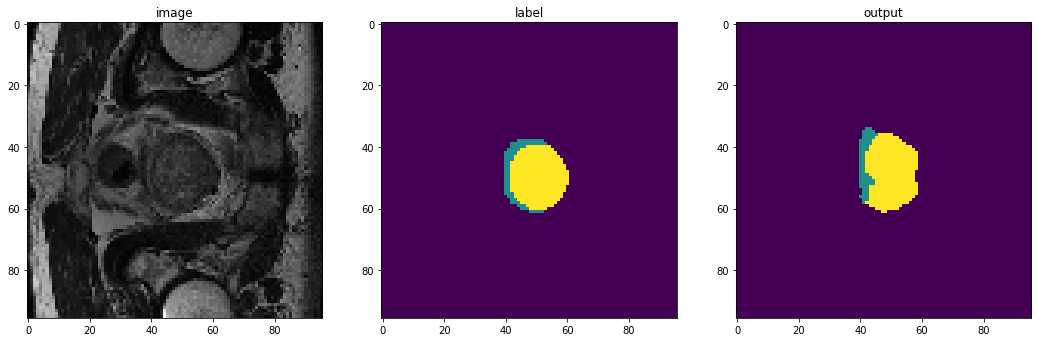

In [61]:

model.eval()
# model.load_from_checkpoint(os.path.join(path, "best_metric_model.ckpt"))
# model.eval()
model.to(device)
net = model

with torch.no_grad():
    img_name = os.path.split(
        val_ds[case_num]["image_meta_dict"]["filename_or_obj"]
    )[1]
    img = val_ds[case_num]["image"].to(device)
    label = val_ds[case_num]["label"].to(device)
    print(img.shape)
    print(label.shape)
    val_inputs = torch.unsqueeze(img, 0).to(device)
    val_labels = torch.unsqueeze(label, 1).to(device)
    print(val_inputs.shape)
    print(val_labels.shape)
    #images, roi_size, sw_batch_size, self.forward
    val_outputs = sliding_window_inference(
        val_inputs, (96,96, 16),1, net, overlap=0.6
    )
    plt.figure("check", (18, 6))
    plt.subplot(1, 3, 1)
    plt.title(f"image")
    plt.imshow(val_inputs.cpu().numpy()[0, 0, :, :,slice_id], cmap="gray")
    plt.subplot(1, 3, 2)
    plt.title(f"label")
    plt.imshow(val_labels.cpu().numpy()[0, 0, :, :, slice_id])
    plt.subplot(1, 3, 3)
    plt.title(f"output")
    plt.imshow(
        torch.argmax(val_outputs, dim=1).detach().cpu()[0, :, :, slice_id]
    )
    plt.show()

In [58]:
val_loader = DataLoader(val_ds, batch_size=2, shuffle=False, num_workers=2)


In [59]:

checkpoint_callback = ModelCheckpoint(dirpath=root_dir, filename="best_metric_model")

# name = "full_" + str(config["epochs"]) + "_" + str(config["batch_size"]) + "_" + str(config["lr"])

config_wdb={"epochs": config["epochs"], 
        "batch_size": config["batch_size"], 
        "roi_size": config["roi_size"],
        'num_heads': config['num_heads']}

#wandb.init(project = "unetr_seg", config=config, name = name)
# wandb_logger = WandbLogger(project='unetr_seg', name = name) 
# wandb_logger.experiment.config.update(config_wdb)


#add gpu
trainer = pl.Trainer( max_epochs=model.max_epochs, 
                     log_every_n_steps=1, check_val_every_n_epoch=1, 
                     callbacks=checkpoint_callback)

# train
# trainer.fit(model,train_loader,train_val_loader)

# wandb.finish()

trainer.validate(model,val_loader)


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/trainer.py:1765: PossibleUserWarning: GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.
  category=PossibleUserWarning,


Validation: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:766: UserWarning: Modifying image pixdim from [0.625 0.625 3.6   1.   ] to [  0.625        0.625        3.5999999  142.87013615]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:766: UserWarning: Modifying image pixdim from [0.6       0.6000003 4.0000024 1.       ] to [  0.60000002   0.60000034   4.00000227 149.31681629]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:766: UserWarning: Modifying image pixdim from [0.625   0.625   3.60001 1.     ] to [  0.625        0.625        3.60000992 173.25173679]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:766: UserWarning: Modifying image pixdim from [0.625 0.625 3.6   1.   ] to [  0.625        0.625        3.5999999  175.63640641]
  warnings.warn(f"Modif

current epoch: 0 current mean dice: 0.6459
best mean dice: 0.6459 at epoch: 0


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│    mean_val_epoch_dice    │    0.6458578705787659     │
│    mean_val_epoch_loss    │    0.23710185289382935    │
│         val_loss          │    0.4742037057876587     │
└───────────────────────────┴───────────────────────────┘

[{'mean_val_epoch_dice': 0.6458578705787659,
  'mean_val_epoch_loss': 0.23710185289382935,
  'val_loss': 0.4742037057876587}]